# Before you get started

## Data formatting

MINER is optimized for expression data of the form log2(TPM+1) or log2(FPKM+1). Expression data in counts format is not currently supported. 

If expression data is not Homo Sapiens, a reference database must be provided for mechanistic inference.

## Data location

This tutorial will import data stored in the "miner/data" folder. Before you start, move your data to the "miner/data" folder. 

## Special dependencies

These dependencies are not required for coexpression clustering or mechanistic inference, but are employed for optional functions in the miner library

Survival analysis:
    install lifelines

# Begin miner analysis

## Import standard dependencies

In [1476]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.manifold import TSNE
import pickle
import miner
%matplotlib inline

## Create directory to save output files

In [1050]:
# create name for results folder where output files will be saved
resultsFolder = "results_tpm_preprocess_alternative"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load previous results (skip if results have not previously been generated)

In [3]:
# If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(resultsDirectory,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(resultsDirectory,"coexpressionModules.json"))
regulons = miner.read_json(os.path.join(resultsDirectory,"regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(resultsDirectory,"mechanisticOutput.json"))

## Pre-process expression data

In [1443]:
expressionData = pd.read_csv("/Users/MattWall/Desktop/IA12Files/MMRF_CoMMpass_IA12a_E74GTF_Sailfish_Gene_TPM.txt",header=0,index_col=0,sep="\t")
expressionData, conversionTable = miner.identifierConversion(expressionData)
expressionData = expressionData.loc[np.count_nonzero(expressionData,axis=1)>=0.1*expressionData.shape[1],:]
expressionData = expressionData[expressionData[expressionData.columns[0]].notnull()]
expressionData2 = batchScale(expressionData)
expressionData2_test = expressionData2.copy()
expressionData2_test[expressionData2_test<2] = 0
expressionData = expressionData2_test.loc[np.count_nonzero(expressionData2_test,axis=1)>=0.1*expressionData2_test.shape[1],:]


completed identifier conversion.
19273 genes were converted.


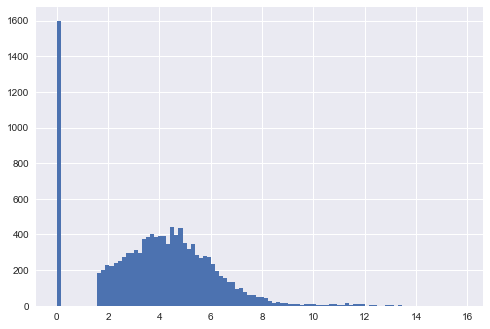

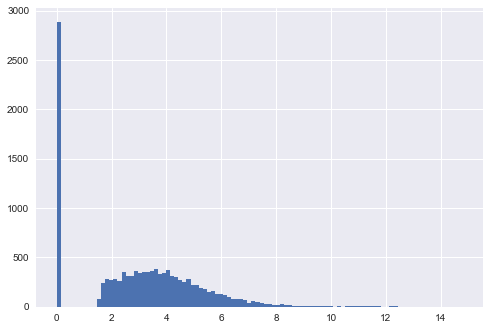

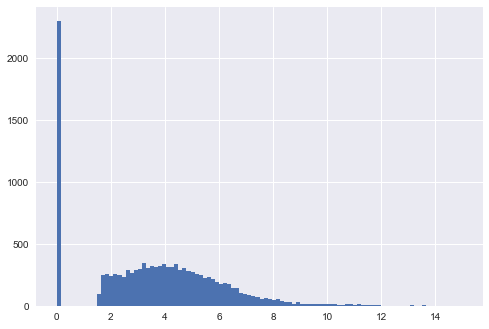

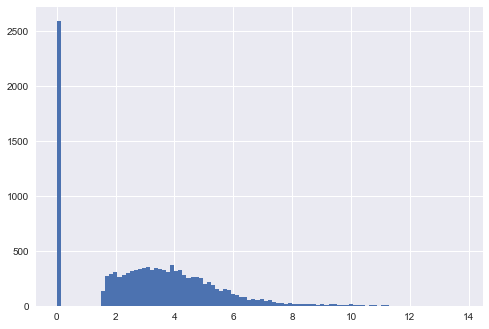

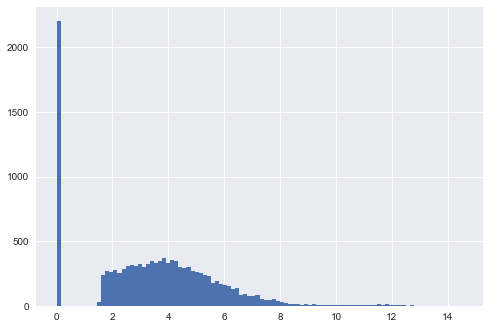

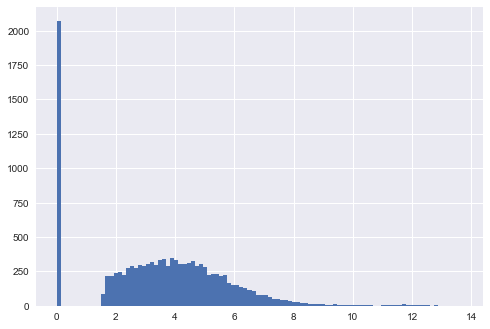

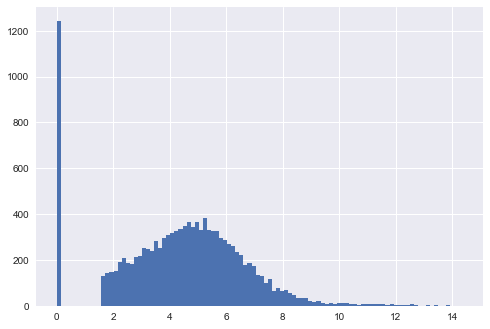

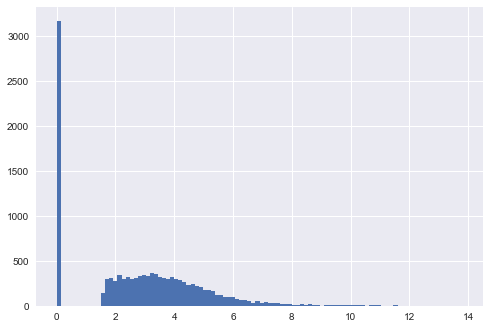

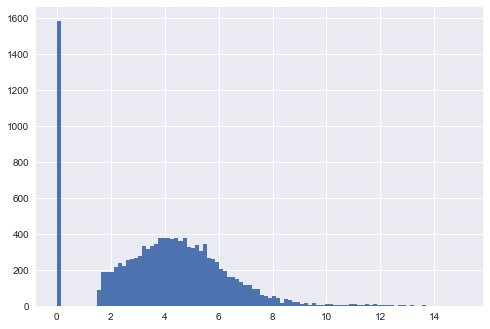

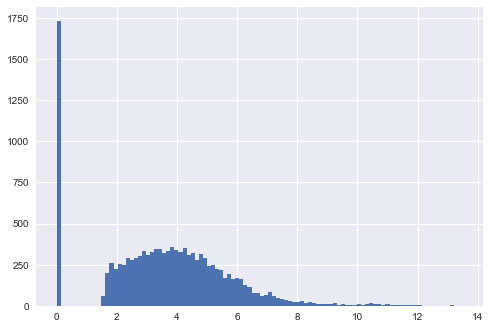

In [1444]:
for i in range(10):
    plt.figure()
    plt.hist(np.log2(expressionData.iloc[:,i]+1),bins=100)

In [1445]:
expressionData.shape

(12315, 881)

In [1389]:
reload(miner)
#expressionData = pd.read_csv(os.path.join("..","data","IA12Zscore.csv"),index_col=0,header=0)
expressionData = pd.read_csv("/Users/MattWall/Desktop/IA12_preprocess_2.csv",header=0,index_col=0)

expressionData, conversionTable = miner.identifierConversion(expressionData)
expressionData = miner.zscore(expressionData)

completed identifier conversion.
16164 genes were converted.
completed z-transformation.


## Set parameters

In [1052]:
# minimum number of genes that form an acceptable coexpression cluster:
minNumberGenes = 6 #bulk RNAseq default=6;single cell RNAseq default=6

# minimum correlation coefficient for an acceptable regulator-cluster association 
minCorrelation = 0.2 #bulk RNAseq default=0.2;single cell RNAseq default=0.05

# minimum number of genes that form an acceptable coexpression cluster and have share binding site for regulator:
minNumberRegulonGenes = 5 #bulk RNAseq default=5;single cell RNAseq default=4

# number of cores available for multiprocessing
numCores = 5

## Co-expression clustering

0.00 percent complete
20.00 percent complete
40.00 percent complete
60.00 percent complete
80.00 percent complete

coexpression clustering completed in 4.74 minutes
Number of genes clustered: 15196
Number of unique clusters: 1233


Text(0,0.5,u'Number of clusters')

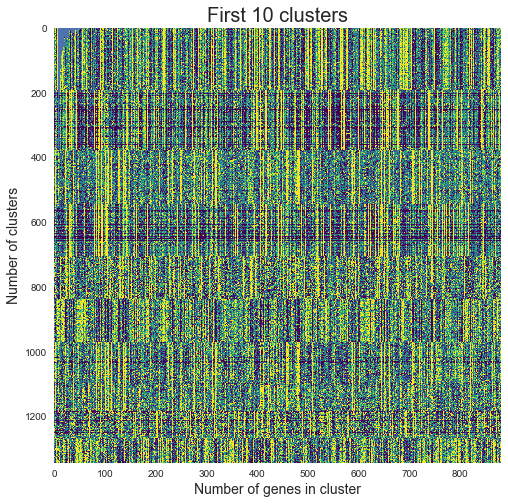

In [1053]:
t_start = time.time()
reload(miner)
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initialClusters = miner.cluster(expressionData,minNumberGenes = minNumberGenes,minNumberOverExpSamples=4,maxSamplesExcluded=0.50,random_state=12,overExpressionThreshold=80) 
# revise initialClusters to combine highly correlated clusters and keep only those with significant coexpression
revisedClusters = miner.reviseInitialClusters(initialClusters,expressionData)
# write revisedClusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary.json"))

# visualize first 10 clusters
plt.figure(figsize=(8,8))
plt.imshow(expressionData.loc[np.hstack([revisedClusters[i] for i in range(10)]),:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",FontSize=20)
plt.xlabel("Samples",FontSize=20)
plt.title("First 10 clusters",FontSize=20)

# report coverage
print("Number of genes clustered: {:d}".format(len(set(np.hstack(initialClusters)))))
print("Number of unique clusters: {:d}".format(len(revisedClusters)))

# plot histogram of the cluster size distribution
counts_ = plt.hist([len(revisedClusters[key]) for key in revisedClusters.keys()],bins=100)
plt.xlabel("Number of genes in cluster",FontSize=14)
plt.ylabel("Number of clusters",FontSize=14)

## Mechanistic inference (only supported for Homo Sapiens)

In [1054]:
reload(miner)
t1 = time.time()
# get first principal component axes of clusters
axes = miner.principalDf(revisedClusters,expressionData,subkey=None,minNumberGenes=1)
# analyze revised clusters for enrichment in relational database (default: transcription factor binding site database)
mechanisticOutput = miner.mechanisticInference(axes,revisedClusters,expressionData,correlationThreshold=minCorrelation,numCores=numCores,dataFolder=os.path.join("..","data"))
# write mechanistic output to .json file
miner.write_json(mechanisticOutput,os.path.join(resultsDirectory,"mechanisticOutput.json"))
# order mechanisticOutput as {tf:{coexpressionModule:genes}} 
coregulationModules = miner.getCoregulationModules(mechanisticOutput)
# write coregulation modules to .json file
miner.write_json(coregulationModules,os.path.join(resultsDirectory,"coregulationModules.json"))
# get final regulons by keeping genes that requently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulationModules,minNumberGenes=minNumberRegulonGenes,freqThreshold = 0.333)
# reformat regulon dictionary for consistency with revisedClusters and coexpressionModules
regulonModules, regulonDf = miner.regulonDictionary(regulons)
# write regulons to json file
miner.write_json(regulonModules,os.path.join(resultsDirectory,"regulons.json"))
# define coexpression modules as composite of coexpressed regulons
coexpressionModules = miner.getCoexpressionModules(mechanisticOutput)
# write coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules.json"))
#reconvert revised clusters to original gene annotations
annotatedRevisedClusters = miner.convertDictionary(revisedClusters,conversionTable)
# write annotated coexpression clusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary_annotated.json"))
#reconvert results into original annotations
regulonAnnotatedDf = miner.convertRegulons(regulonDf,conversionTable)
#write annotated regulon table to .csv
regulonAnnotatedDf.to_csv(os.path.join(resultsDirectory,"regulons_annotated.csv"))
#reconvert regulons
annotatedRegulons = miner.convertDictionary(regulonModules,conversionTable)
# write annotated regulons to .json file
miner.write_json(regulons,os.path.join(resultsDirectory,"regulons_annotated.json"))
#reconvert coexpression modules
annotatedCoexpressionModules = miner.convertDictionary(coexpressionModules,conversionTable)
# write annotated coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules_annotated.json"))
t2 = time.time()
print("completed mechanistic inference in {:.2f} minutes".format((t2-t1)/60.))
print(len(regulonDf.Regulator.unique()),len(regulonDf.Gene.unique()))

0
246
249
247
248
1
250
494
492
2
251
493
252
741
739
495
253
740
254
496
742
255
986
987
497
743
498
256
988
499
257
744
989
258
500
259
3
501
990
745
991
746
502
260
992
747
261
503
993
748
994
995
504
262
996
505
749
997
4
506
998
507
508
750
263
999
751
509
1000
1001
264
510
1002
1003
752
1004
1005
511
1006
1007
753
265
1008
266
754
512
5
1009
267
755
1010
268
513
1011
514
756
1012
269
1013
515
1014
1015
757
1016
1017
758
516
1018
1019
270
1020
759
1021
517
271
760
1022
518
1023
272
761
1024
519
6
1025
762
1026
273
763
1027
1028
1029
520
1030
764
1031
1032
521
1033
765
522
274
766
523
767
1034
275
524
768
769
525
770
1035
276
771
277
526
527
772
1036
773
528
774
529
7
775
530
278
1037
776
531
532
777
1038
533
279
778
1039
534
779
535
280
1040
536
780
281
8
781
1041
782
783
1042
537
282
784
1043
785
283
538
1044
786
9
787
284
1045
788
539
1046
285
789
1047
286
790
540
1048
287
791
10
1049
541
288
792
1050
793
1051
542
794
289
1052
795
1053
543
1054
796
1055
290
11
291
797
1056
1057


## Infer bicluster membership

In [1088]:
reload(miner)
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = regulonModules
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each cluster, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)
# for each cluster, give samples that do not show coherent cluster activity
dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))
dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"dysregulatedMembers.csv"))
coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"coherentMembers.csv"))

done!


## Infer subtypes

done!
12
21
13
12
12
8
11
2
8
3
3
2
2
3
2
2
2
Discovered 23 transcriptional states and 87 transcriptional programs
sample coverage within sufficiently large states: 98.6%


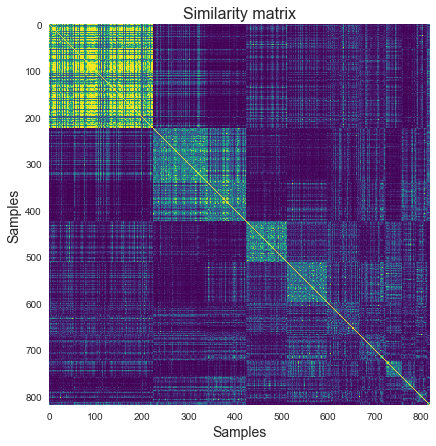

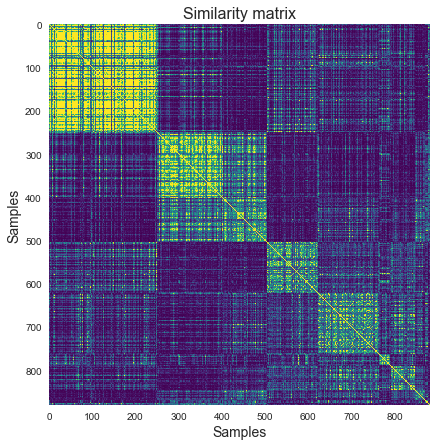

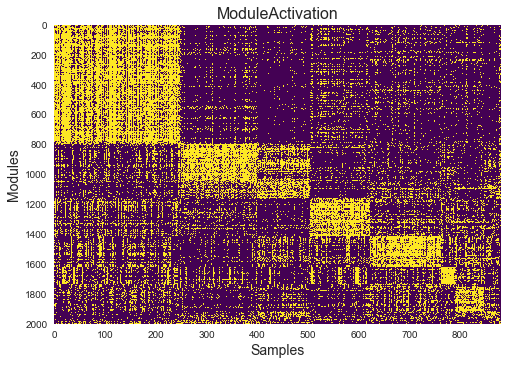

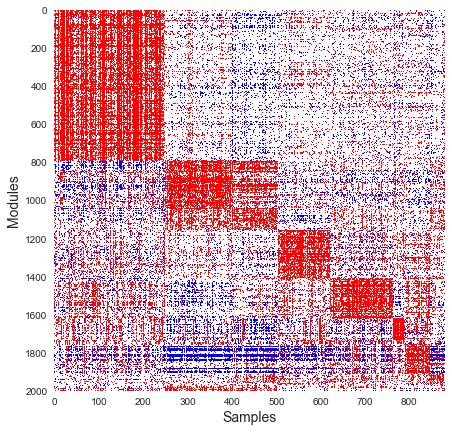

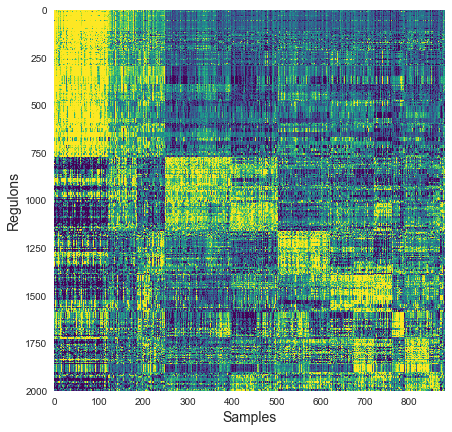

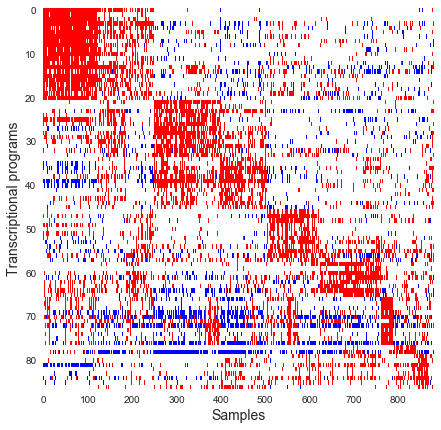

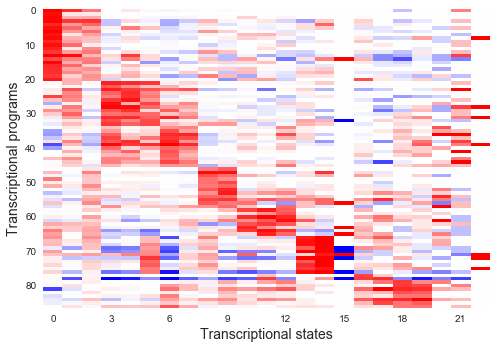

In [1056]:
# choose membership type for sample class prediction
sampleDictionary = overExpressedMembers
sampleMatrix = overExpressedMembersMatrix
sampleUnderMatrix = underExpressedMembersMatrix

# perform initial subtype clustering
similarityClusters = miner.f1Decomposition(sampleDictionary,thresholdSFM=0.1)
initialClasses = [i for i in similarityClusters if len(i)>4]

# visualize initial results
sampleFrequencyMatrix = miner.sampleCoincidenceMatrix(sampleDictionary,freqThreshold = 0.333,frequencies=True) #0.333
similarityMatrix = sampleFrequencyMatrix*sampleFrequencyMatrix.T
miner.plotSimilarity(similarityMatrix,np.hstack(initialClasses),vmin=0,vmax=0.5,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(resultsDirectory,"similarityMatrix_regulons.pdf"))

# expand initial subtype clusters
centroidClusters, centroidMatrix = miner.centroidExpansion(initialClasses,sampleMatrix,f1Threshold = 0.1,returnCentroids=True) #0.3
centroidMatrix.to_csv(os.path.join(resultsDirectory,"centroids.csv"))
unmapped = list(sampleMatrix.columns[np.where(sampleMatrix.sum(axis=0)==0)[0]])
mappedSamples = [i for i in np.hstack(centroidClusters) if i not in unmapped]
mappedClusters = miner.mapExpressionToNetwork(centroidMatrix,sampleMatrix,threshold = 0.05)

# visualize expanded subtype clusters
miner.plotSimilarity(similarityMatrix,mappedSamples,vmin=0,vmax=0.333,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(resultsDirectory,"centroidClusters_regulons.pdf"))

# Generate heatmaps of module activity
orderedOverExpressedMembers = miner.orderMembership(centroidMatrix,sampleMatrix,mappedClusters,ylabel="Modules",resultsDirectory=None)
orderedDM = miner.plotDifferentialMatrix(overExpressedMembersMatrix,underExpressedMembersMatrix,orderedOverExpressedMembers,cmap="bwr",aspect="auto",saveFile=os.path.join(resultsDirectory,"centroid_clusters_heatmap.pdf"))

# Infer transcriptional programs and states
programs, states = miner.mosaic(dfr=orderedDM,clusterList=centroidClusters,minClusterSize_x=9,minClusterSize_y=5,allow_singletons=False,max_groups=50,saveFile=os.path.join(resultsDirectory,"regulon_activity_heatmap.pdf"),random_state=12)   
transcriptional_programs, program_regulons = miner.transcriptionalPrograms(programs,referenceDictionary)
program_list = [program_regulons[("").join(["TP",str(i)])] for i in range(len(program_regulons))]
mosaicDf = orderedDM.loc[np.hstack(program_list),np.hstack(states)]
mosaicDf.to_csv(os.path.join(resultsDirectory,"regulons_activity_heatmap.csv"))

# Get eigengenes for all modules
eigengenes = miner.getEigengenes(referenceDictionary,expressionData,regulon_dict=None,saveFolder=None)

#write eigengenes to .csv
eigengenes.to_csv(os.path.join(resultsDirectory,"eigengenes.csv"))

#plot eigengenes
plt.figure()
plt.imshow(eigengenes.loc[np.hstack(program_list),np.hstack(states)],cmap="viridis",vmin=-0.05,vmax=0.05,aspect="auto")
plt.grid(False)

# calculate percent of samples that fall into a state with >= minimum acceptable number of samples
groups = [states[i] for i in range(len(states)) if len(states[i])>=int(np.ceil(0.01*expressionData.shape[1]))]
print('Discovered {:d} transcriptional states and {:d} transcriptional programs'.format((len(states)),len(transcriptional_programs)))
print('sample coverage within sufficiently large states: {:.1f}%'.format(100*float(len(np.hstack(groups)))/expressionData.shape[1]))

#write all transcriptional program genesets to text files for external analysis
if not os.path.isdir(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules")):
    os.mkdir(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules"))
    
for tp in transcriptional_programs.keys():
    np.savetxt(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules",(".").join([tp,"txt"])),transcriptional_programs[tp],fmt="%1.50s")
    
# Determine activity of transcriptional programs in each sample
statesDf = miner.reduceModules(df=orderedDM,programs=program_list,states=states,stateThreshold=0.65,saveFile=os.path.join(resultsDirectory,"transcriptional_programs_vs_samples.pdf"))

# Cluster patients into subtypes and give the activity of each program in each subtype
programsVsStates = miner.programsVsStates(statesDf,states,filename=os.path.join(resultsDirectory,"programs_vs_states.pdf"))

# Visualize with tSNE

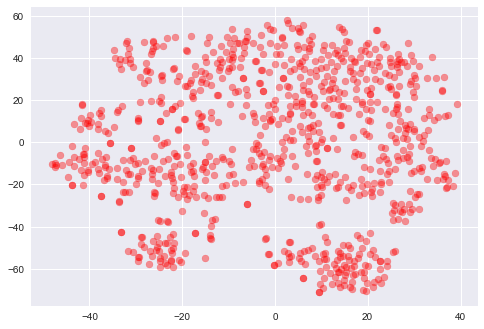

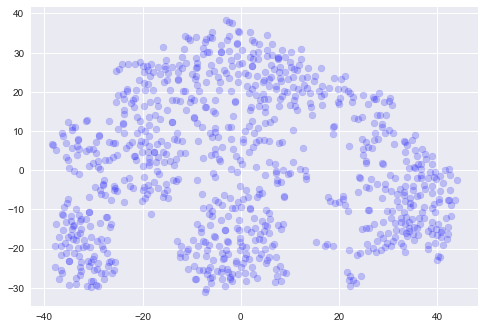

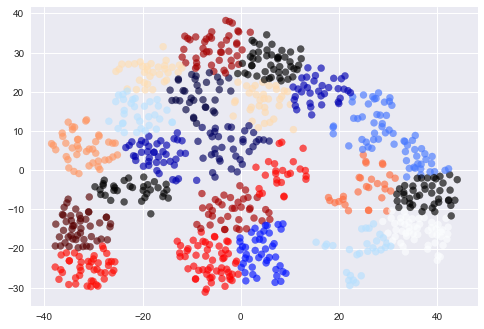

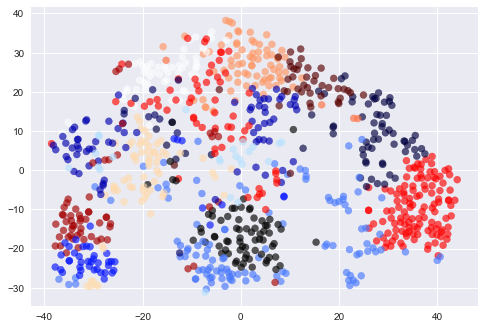

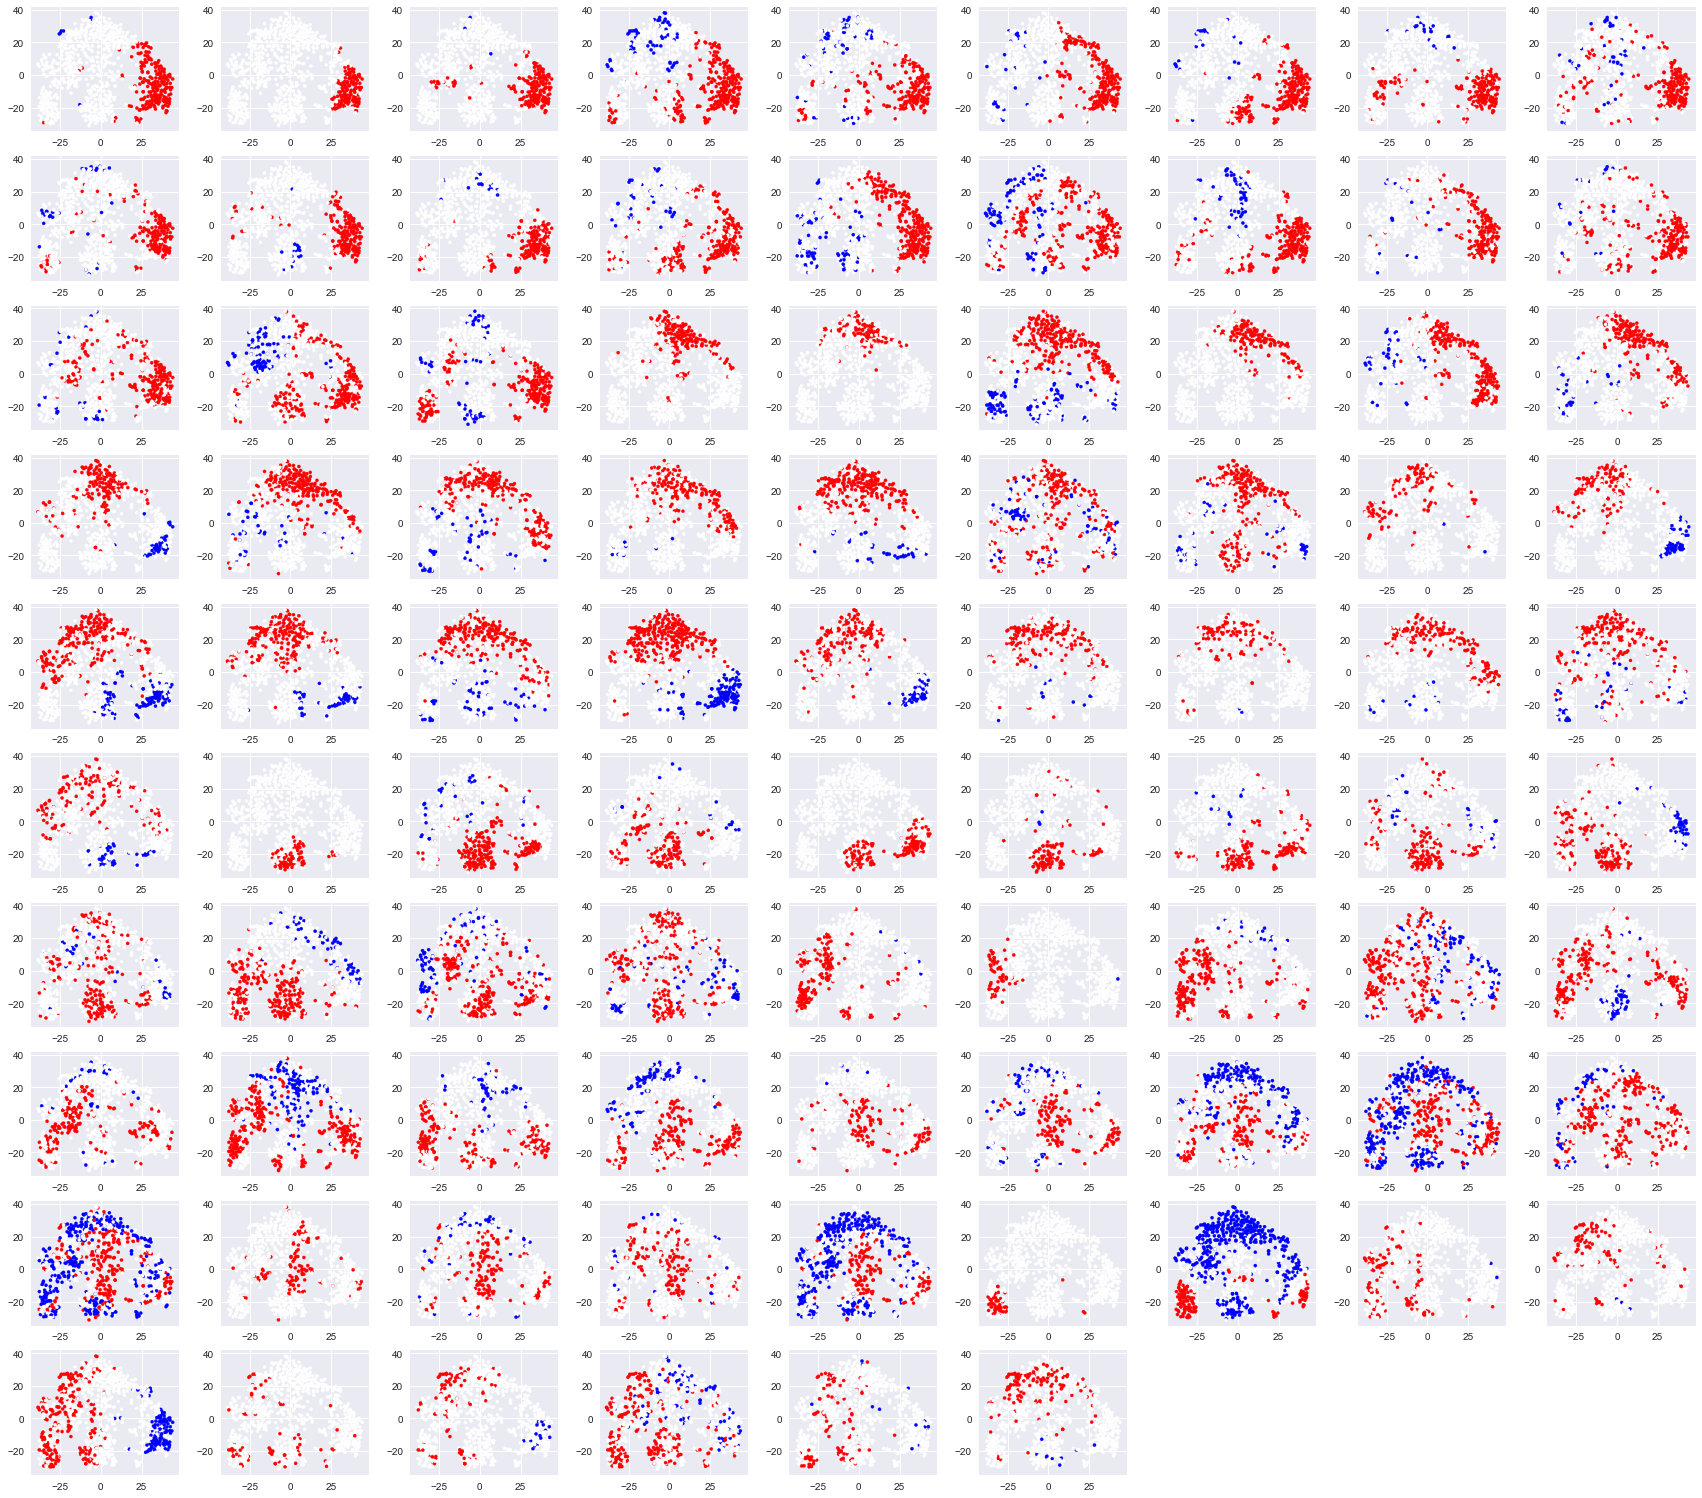

In [1057]:
# tSNE applied to expressionData. Set plotOnly = False to return tSNE coordinates
# consider changing the perplexity to explore different degrees of cluster separation
miner.tsne(expressionData,perplexity=15,n_components=2,n_iter=1000,plotOnly=True,plotColor="red",alpha=0.4)
plt.savefig(os.path.join(resultsDirectory,"tsne_gene_expression.pdf"),bbox_inches="tight")

# tSNE applied to df_for_tsne. Consider changing the perplexity in the range of 5 to 50
df_for_tsne = mosaicDf.copy()
plt.figure()
X_embedded = miner.tsne(df_for_tsne,perplexity=30,n_components=2,n_iter=1000,plotOnly=None,plotColor="blue",alpha=0.2)
tsneDf = pd.DataFrame(X_embedded)
tsneDf.index = df_for_tsne.columns
tsneDf.columns = ["tsne1","tsne2"]
plt.savefig(os.path.join(resultsDirectory,"tsne_regulon_activity.pdf"),bbox_inches="tight")

# How many clusters do you expect? Start with number of states
numberOfClusters = len(states)

# Are the clusters separated how you thought? If not, change the random_state to a different number and retry
random_state=12

clusters, labels, centroids = miner.kmeans(tsneDf,numClusters=numberOfClusters,random_state=random_state)

# overlay kmeans cluster labels
plt.figure()
plt.scatter(tsneDf.iloc[:,0],tsneDf.iloc[:,1],cmap="tab20",c=labels,alpha=0.65)
plt.savefig(os.path.join(resultsDirectory,"labeled_tsne_kmeans.pdf"),bbox_inches="tight")

# convert states to tsne labels
state_labels = miner.tsneStateLabels(tsneDf,states)

# overlay states cluster labels
plt.figure()
plt.scatter(tsneDf.iloc[:,0],tsneDf.iloc[:,1],cmap="tab20",c=state_labels,alpha=0.65)
plt.savefig(os.path.join(resultsDirectory,"labeled_tsne_states.pdf"),bbox_inches="tight")

# overlay activity of transcriptional programs
miner.plotStates(statesDf,tsneDf,numCols=int(np.sqrt(statesDf.shape[0])),saveFile = os.path.join(resultsDirectory,("_").join(["states_regulons",("").join(["0o",str(minCorrelation).split(".")[1]]),"tsne.pdf"])),aspect=1,size=10,scale=3)

# Survival analysis

23
10
10
10
10
10


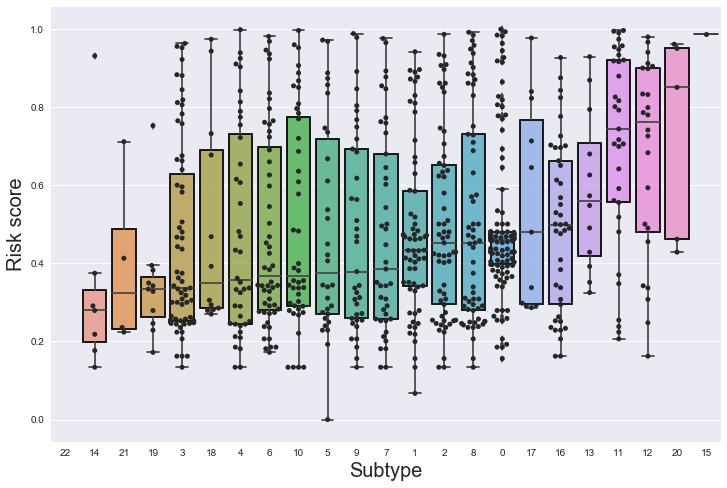

In [1058]:
# load survival data
survivalMMRF = pd.read_csv(os.path.join("..","data","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
overExpressedMembersMatrixMMRF = overExpressedMembersMatrixMMRF.loc[orderedOverExpressedMembers.index,:]

#generate Kaplan-Meier estimates
kmDf = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfMMRF = miner.guanRank(kmSurvival=kmDf)

# Visualize risk associated with each transcriptional state

srv = guanSurvivalDfMMRF.copy()
guan_srv = pd.DataFrame(srv.loc[:,"GuanScore"])
guan_srv.columns = ["value"]
guan_srv_group = pd.DataFrame(-np.ones(guan_srv.shape[0]))
guan_srv_group.index = guan_srv.index
guan_srv_group.columns = ["group"]
guan_srv_df = pd.concat([guan_srv,guan_srv_group],axis=1)

mmrf_groups = states

labels = range(len(mmrf_groups))

xmedians = []
for i in range(len(mmrf_groups)):
    group = list(set(srv.index)&set(mmrf_groups[i]))
    if len(group)>=1:
        xmedians.append(np.median(guan_srv_df.loc[group,"value"]))
    elif len(group)<1:
        xmedians.append(0)
    label = labels[i]
    guan_srv_df.loc[group,"group"] = label
print(len(xmedians))

ranked_states = np.argsort(xmedians)

survival_tag = "Risk_groups"
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='group', y='value', data=guan_srv_df,order=ranked_states)
for patch in ax.artists:
    patch.set_edgecolor('black')
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.8))

sns.swarmplot(x='group', y='value',data=guan_srv_df,order=np.argsort(xmedians),size=5, color=[0.15,0.15,0.15],edgecolor="black")
    
plt.ylabel("Risk score",FontSize=20)
plt.xlabel("Subtype",FontSize=20)
boxplotFilename = ("_").join([survival_tag,"boxplot_swarm.pdf"])
plt.savefig(os.path.join(resultsDirectory,boxplotFilename),bbox_inches="tight")


# proportional hazards regression of transcriptional programs
cox_programs = miner.parallelMemberSurvivalAnalysis(membershipDf = statesDf,numCores=5,survivalPath="",survivalData=srv)

cox_programs_hr = [cox_programs[i][0] for i in range(len(cox_programs))]
cox_programs_p = [cox_programs[i][1] for i in range(len(cox_programs))]
cox_programs_df = pd.DataFrame(np.vstack([cox_programs_hr,cox_programs_p]).T)
cox_programs_df.index = [cox_programs.keys()[i] for i in range(len(cox_programs))]
cox_programs_df.columns = ["HR","p-value"]
cox_programs_df.sort_values(by="HR",ascending=False,inplace=True)

# proportional hazards regression of transcriptional states
state_members = [states[i] for i in range(len(states)) if len(states[i])>=9]
sufficient_states = [i for i in range(len(states)) if len(states[i])>=9]
state_survival = pd.DataFrame(np.zeros((len(state_members),srv.shape[0])))
state_survival.index = sufficient_states
state_survival.columns = srv.index
for ix in range(len(sufficient_states)):
    sm = list(set(state_members[ix])&set(srv.index))
    state_survival.loc[sufficient_states[ix],sm] = 1
    
cox_states = miner.parallelMemberSurvivalAnalysis(membershipDf = state_survival,numCores=5,survivalPath="",survivalData=srv)

cox_hr = [cox_states[i][0] for i in cox_states.keys()]
cox_p = [cox_states[i][1] for i in cox_states.keys()]
cox_df = pd.DataFrame(np.vstack([cox_hr,cox_p]).T)
cox_df.index = cox_states.keys()
cox_df.columns = ["HR","p-value"]
cox_df.sort_values(by="HR",ascending=False,inplace=True)

## Combinatorial survival analysis

10
                               HR       p-value
20&12&11&13              6.933803  4.096742e-12
20&12&11                 6.768447  1.301718e-11
20&12&11&13&16&17        5.517576  3.437084e-08
20&12&11&13&16           5.515749  3.472976e-08
20&12                    4.500481  6.779986e-06
20&12&11&13&16&17&0      4.477502  7.552167e-06
20&12&11&13&16&17&0&8    4.150062  3.323858e-05
20&12&11&13&16&17&0&8&2  3.900529  9.598284e-05
20                       3.129573  1.750603e-03
14                      -1.550296  1.210705e-01
14&21                   -1.736710  8.243841e-02
14&21&19                -2.475583  1.330189e-02
14&21&19&3&18           -2.554898  1.062188e-02
14&21&19&3              -2.633929  8.440323e-03
14&21&19&3&18&4         -2.809741  4.958133e-03
14&21&19&3&18&4&6&10    -2.851412  4.352553e-03
14&21&19&3&18&4&6       -2.861302  4.219050e-03
14&21&19&3&18&4&6&10&5  -3.018295  2.542017e-03


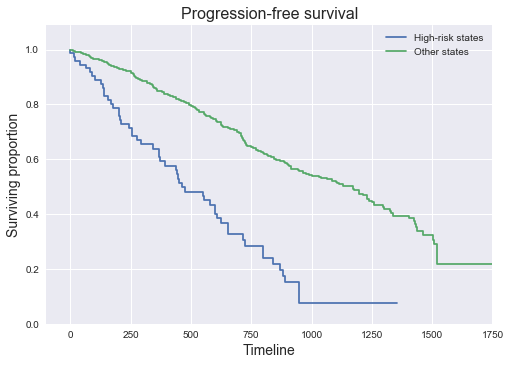

In [1059]:
combined_states, combined_indices = miner.combinedStates(mmrf_groups,ranked_states,srv,minSamples=4,maxStates=10)

state_members = combined_states
sufficient_states = range(len(combined_states))
state_survival = pd.DataFrame(np.zeros((len(state_members),srv.shape[0])))
state_survival.index = sufficient_states
state_survival.columns = srv.index
for ix in range(len(sufficient_states)):
    sm = list(set(state_members[ix])&set(srv.index))
    state_survival.loc[sufficient_states[ix],sm] = 1
    
cox_combined_states = miner.parallelMemberSurvivalAnalysis(membershipDf = state_survival,numCores=1,survivalPath="",survivalData=srv)

cox_hr = [cox_combined_states[i][0] for i in cox_combined_states.keys()]
cox_p = [cox_combined_states[i][1] for i in cox_combined_states.keys()]
cox_combined_states_df = pd.DataFrame(np.vstack([cox_hr,cox_p]).T)
cox_combined_states_df.index = combined_indices
cox_combined_states_df.columns = ["HR","p-value"]
cox_combined_states_df.sort_values(by="HR",ascending=False,inplace=True)
cox_combined_states_df.to_csv(os.path.join(resultsDirectory,"Hazards_regression_of_combined_transcriptional_states.csv"))
print(cox_combined_states_df)

highest_risk_combination = np.array(cox_combined_states_df.index[0].split("&")).astype(int)
lowest_risk_combination = np.array(cox_combined_states_df.index[-1].split("&")).astype(int)

kmTag = "states"
kmFilename = ("_").join([survival_tag,kmTag,".pdf"])
groups = [np.hstack([states[i] for i in highest_risk_combination]),np.hstack([states[i] for i in range(len(states)) if i not in highest_risk_combination])]
labels = np.arange(len(groups)).astype(str)
labels = ["High-risk states","Other states"]
plotName = os.path.join(resultsDirectory,kmFilename)
miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),filename=plotName)    

In [1060]:
t_stop = time.time()
print("completed all modules in {:.2f} minutes".format((t_stop-t_start)/60.))

completed all modules in 93.26 minutes


## Mutation analysis

In [26]:
mutations = pd.read_csv(os.path.join(resultsDirectory,"..","data","filteredMutationsIA12.csv"),index_col=0,header=0)
translocations = pd.read_csv(os.path.join(resultsDirectory,"..","data","translocationsIA12.csv"),index_col=0,header=0)
cytogenetics = pd.read_csv(os.path.join(resultsDirectory,"..","data","cytogenetics.csv"),index_col=0,header=0)

epigenetic_matrix = miner.generateEpigeneticMatrix("epigenes.txt",expressionData,cutoff_pecentile=80,saveFile="epigeneticMatrix.csv")

MMRF_1017_1_BM  MMRF_1024_1_BM  MMRF_1024_3_BM  MMRF_1038_1_BM  \
del13               0               0               0               0   
del17               0               0               0               0   
t414                0               0               0               0   
t1114               0               0               0               0   
t1416               0               0               0               0   

       MMRF_1033_1_BM  MMRF_1007_1_BM  MMRF_1052_1_BM  MMRF_1082_1_BM  \
del13               0               0               0               0   
del17               0               0               0               0   
t414                0               0               0               0   
t1114               0               0               0               1   
t1416               0               0               0               1   

       MMRF_1094_1_BM  MMRF_1093_1_BM       ...        MMRF_2836_1_BM  \
del13               0               0       ...                     0   
del17               0               0       ...                     0   
t414                0               0       ...                     0   
t1114               0               0       ...                     1   
t1416               0               0       ...                     0   

       MMRF_2838_1_BM  MMRF_2839_1_BM  MMRF_2840_1_BM  MMRF_2843_1_BM  \
del13               1               1               0               0   
del17               0               0               0               0   
t414                1               1               0               0   
t1114               0               0               0               0   
t1416               0               0               0               0   

       MMRF_2846_1_BM  MMRF_2847_1_BM  MMRF_2848_1_BM  MMRF_2851_1_BM  \
del13               1               0               0               1   
del17               0               0               0               0   
t414                1               0               1               0   
t1114               0               0               0               1   
t1416               0               0               0               0   

       MMRF_2853_1_BM  
del13               0  
del17               0  
t414                0  
t1114               0  
t1416               0  

[5 rows x 1224 columns]

In [66]:
commonMutations = mutations[mutations.sum(axis=1)>=18]
commonMutations.to_csv(os.path.join(resultsDirectory,"..","data","commonMutations.csv"))

rareMutations = mutations[np.logical_and(mutations.sum(axis=1)<18,mutations.sum(axis=1)>=9)]
rareMutations.to_csv(os.path.join(resultsDirectory,"..","data","rareMutations.csv"))

## Causal inference

In [106]:
reload(miner)
mutationFile = "epigeneticMatrix.csv"
columnSubset = list(set(epigenetic_matrix.columns)&set(expressionData.columns))
miner.generateCausalInputs(expressionData.loc[:,columnSubset],mechanisticOutput,coexpressionModules,saveFolder=resultsDirectory,regulon_dict=regulons,mutationFile=mutationFile)    

## Pause to run NEO using the minerNEO notebook

## Continue causal inference

In [117]:
# After running NEO (in R), proceed with the following
preProcessedCausalResults = miner.processCausalResults(causalPath=os.path.join(resultsDirectory,"causal_epigenetics"))
# load complete mutation matrix with default filters for use in postprocessing
filteredMutations = miner.mutationMatrix(mutationPath=os.path.join(os.path.split(os.getcwd())[0],"data"),mutationFiles = [mutationFile],minNumMutations=None)
# load tf expression matrix for use in postprocessing
tfExp = miner.tfExpression(expressionData,motifPath=os.path.join(os.path.split(os.getcwd())[0],"data","all_tfs_to_motifs.pkl"))
# load eigengenes matrix for use in postprocessing
eigengenes = pd.read_csv(os.path.join(resultsDirectory,"eigengenes.csv"),index_col=0,header=0)
# generate p values for all network edges for use in filtering
postProcessedCausalAnalysis = miner.postProcessCausalResults(preProcessedCausalResults,filteredMutations,tfExp,eigengenes,mechanisticOutput=None,numCores=numCores)
# write post-processed analysis to json file       
miner.write_json(postProcessedCausalAnalysis,os.path.join(resultsDirectory,"regulonNetworkPValues_epigenetics.json"))     
# generate causal mechanistic network in dataframe format
causalMechanisticNetwork = miner.causalMechanisticNetworkDictionary(postProcessedCausalAnalysis,biclusterRegulatorPvalue=0.05,regulatorMutationPvalue=0.05,mutationFrequency = 0.01,requireCausal=False)
# save causalMechanisticNetwork to csv
causalMechanisticNetwork.to_csv(os.path.join(resultsDirectory,"regulonCausalMechanisticNetworkAll_epigenetics.csv"))


0
0
0
0
0
10
10
10
10
20
10
20
20
20
30
30
30
30
40
20
40
40
50
40
60
50
30
70
60
50
40
50
80
50
60
60
60
70
70
90
80
70
80
90
70
90
100
100
100
110
80
120
110
90
130
120
110
80
100
120
140
150
110
160
120
130
130
170
130
90
180
140
140
140
150
100
190
110
200
120
160
150
150
210
170
220
160
180
190
130
230
200
140
170
240
160
250
260
210
180
150
190
270
200
170
210
220
180
230
190
160
200
280
220
210
290
240
170
220
230
300
180
230
240
250
310
190
250
200
260
240
210
270
220
320
230
280
290
240
260
250
260
250
270
330
280
290
300
260
340
270
350
300
270
360
280
280
310
290
290
370
300
300
310
310
310
320
380
320
390
400
330
330
320
340
410
350
340
320
330
360
420
330
350
340
340
370
350
360
360
380
350
370
370
430
380
390
380
390
440
400
450
410
360
400
460
420
390
410
470
430
420
400
410
370
440
420
380
430
450
480
390
460
440
470
430
480
450
490
440
400
500
460
450
490
470
410
460
510
470
480
480
420
490
520
500
490
500
500
510
530
510
520
430
510
530
540
520
520
550
530
540
540
440

## Validation datasets

## Expression data

In [173]:
reload(miner)
# GSE24080UAMS
expressionDataGSE24080UAMS = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","GSE24080UAMSentrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE24080UAMS, _ = miner.identifierConversion(expressionData=expressionDataGSE24080UAMS)
expressionDataGSE24080UAMS = miner.zscore(expressionDataGSE24080UAMS)
bkgdGSE24080UAMS = miner.backgroundDf(expressionDataGSE24080UAMS)
overExpressedMembersGSE24080UAMS = miner.biclusterMembershipDictionary(regulonModules,bkgdGSE24080UAMS,label=2,p=0.1)
overExpressedMembersMatrixGSE24080UAMS = miner.membershipToIncidence(overExpressedMembersGSE24080UAMS,expressionDataGSE24080UAMS)
overExpressedMembersMatrixGSE24080UAMS = overExpressedMembersMatrixGSE24080UAMS.loc[orderedOverExpressedMembers.index,:]

# GSE19784HOVON65 
expressionDataGSE19784HOVON65 = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","GSE19784HOVON65entrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE19784HOVON65, _ = miner.identifierConversion(expressionData=expressionDataGSE19784HOVON65)
expressionDataGSE19784HOVON65 = miner.zscore(expressionDataGSE19784HOVON65)
bkgdGSE19784HOVON65 = miner.backgroundDf(expressionDataGSE19784HOVON65)
overExpressedMembersGSE19784HOVON65 = miner.biclusterMembershipDictionary(regulonModules,bkgdGSE19784HOVON65,label=2,p=0.1)
overExpressedMembersMatrixGSE19784HOVON65 = miner.membershipToIncidence(overExpressedMembersGSE19784HOVON65,expressionDataGSE19784HOVON65)
overExpressedMembersMatrixGSE19784HOVON65 = overExpressedMembersMatrixGSE19784HOVON65.loc[orderedOverExpressedMembers.index,:]

# EMTAB4032
expressionDataEMTAB4032 = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","EMTAB4032entrezIDlevel.csv"),index_col=0,header=0)
expressionDataEMTAB4032, _ = miner.identifierConversion(expressionData=expressionDataEMTAB4032)
expressionDataEMTAB4032 = miner.zscore(expressionDataEMTAB4032)
bkgdEMTAB4032 = miner.backgroundDf(expressionDataEMTAB4032)
overExpressedMembersEMTAB4032 = miner.biclusterMembershipDictionary(regulonModules,bkgdEMTAB4032,label=2,p=0.1)
overExpressedMembersMatrixEMTAB4032 = miner.membershipToIncidence(overExpressedMembersEMTAB4032,expressionDataEMTAB4032)
overExpressedMembersMatrixEMTAB4032 = overExpressedMembersMatrixEMTAB4032.loc[orderedOverExpressedMembers.index,:]

completed identifier conversion.
16998 genes were converted.
completed z-transformation.
done!
completed identifier conversion.
16998 genes were converted.
completed z-transformation.
done!
completed identifier conversion.
17228 genes were converted.
completed z-transformation.
done!


## Survival data

In [174]:
survival = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","globalClinTraining.csv"),index_col=0,header=0)

survivalGSE24080UAMS = survival[survival.index=='GSE24080UAMS']
survivalGSE24080UAMS.index = survivalGSE24080UAMS.iloc[:,0]
survivalGSE24080UAMS.head(3)
survivalDfGSE24080UAMS = survivalGSE24080UAMS.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfGSE24080UAMS.columns = ["duration","observed"]

survivalGSE19784HOVON65 = survival[survival.index=='HOVON65']
survivalGSE19784HOVON65.index = survivalGSE19784HOVON65.iloc[:,0]
survivalGSE19784HOVON65.head(3)
survivalDfGSE19784HOVON65 = survivalGSE19784HOVON65.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfGSE19784HOVON65.columns = ["duration","observed"]

survivalEMTAB4032 = survival[survival.index=='EMTAB4032']
survivalEMTAB4032.index = survivalEMTAB4032.iloc[:,0]
survivalEMTAB4032.head(3)
survivalDfEMTAB4032 = survivalEMTAB4032.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfEMTAB4032.columns = ["duration","observed"]

In [175]:
#generate Kaplan-Meier estimates
kmDf = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfMMRF = miner.guanRank(kmSurvival=kmDf)

#generate Kaplan-Meier estimates for GuanRank analysis
kmDf = miner.kmAnalysis(survivalDf=survivalDfGSE24080UAMS,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfGSE24080UAMS = miner.guanRank(kmSurvival=kmDf)

#generate Kaplan-Meier estimates for GuanRank analysis
kmDf = miner.kmAnalysis(survivalDf=survivalDfGSE19784HOVON65,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfGSE19784HOVON65 = miner.guanRank(kmSurvival=kmDf)

#generate Kaplan-Meier estimates for GuanRank analysis
kmDf = miner.kmAnalysis(survivalDf=survivalDfEMTAB4032,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfEMTAB4032 = miner.guanRank(kmSurvival=kmDf)

done!
done!


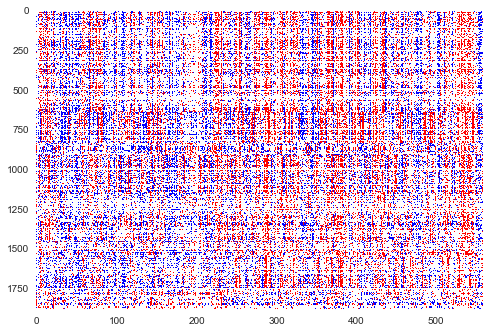

In [278]:
#bc_dictionary = {key:referenceDictionary[key] for key in np.array(big_hits)}
reload(miner)
bc_dictionary = regulonModules
overExpressedMembersGSE24080UAMS = miner.biclusterMembershipDictionary(bc_dictionary,bkgdGSE24080UAMS,label=2,p=0.1)
underExpressedMembersGSE24080UAMS= miner.biclusterMembershipDictionary(bc_dictionary,bkgdGSE24080UAMS,label=0,p=0.1)
overExpressedMembersMatrixGSE24080UAMS = miner.membershipToIncidence(overExpressedMembersGSE24080UAMS,expressionDataGSE24080UAMS)
underExpressedMembersMatrixGSE24080UAMS = miner.membershipToIncidence(underExpressedMembersGSE24080UAMS,expressionDataGSE24080UAMS)

ordered_regulons = orderedDM.index
difference_complete_GSE24080UAMS = overExpressedMembersMatrixGSE24080UAMS-underExpressedMembersMatrixGSE24080UAMS
difference_complete_GSE24080UAMS = difference_complete_GSE24080UAMS.loc[ordered_regulons,:]
plt.imshow(difference_complete_GSE24080UAMS.loc[ordered_regulons,:],cmap="bwr",aspect="auto")

In [884]:
overExpressedMembersMatrixGSE19784HOVON65.shape

(3203, 282)

done!
done!


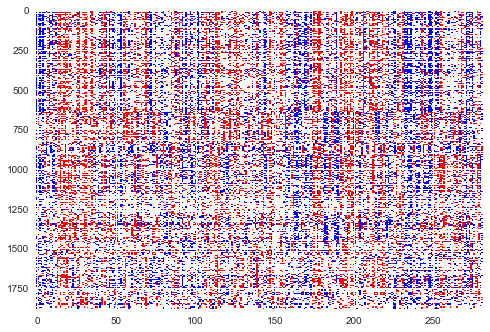

In [356]:
overExpressedMembersGSE19784HOVON65 = miner.biclusterMembershipDictionary(regulonModules,bkgdGSE19784HOVON65,label=2,p=0.1)
underExpressedMembersGSE19784HOVON65 = miner.biclusterMembershipDictionary(regulonModules,bkgdGSE19784HOVON65,label=0,p=0.1)
overExpressedMembersMatrixGSE19784HOVON65 = miner.membershipToIncidence(overExpressedMembersGSE19784HOVON65,expressionDataGSE19784HOVON65)
underExpressedMembersMatrixGSE19784HOVON65 = miner.membershipToIncidence(underExpressedMembersGSE19784HOVON65,expressionDataGSE19784HOVON65)

difference_complete_GSE19784HOVON65 = overExpressedMembersMatrixGSE19784HOVON65-underExpressedMembersMatrixGSE19784HOVON65
difference_complete_GSE19784HOVON65 = difference_complete_GSE19784HOVON65.loc[ordered_regulons,:]
plt.imshow(difference_complete_GSE19784HOVON65.loc[ordered_regulons,:],cmap="bwr",aspect="auto")

done!
done!


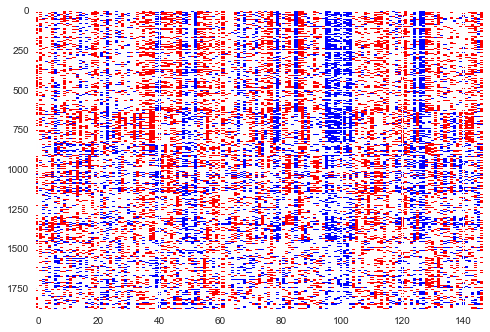

In [357]:
overExpressedMembersEMTAB4032 = miner.biclusterMembershipDictionary(regulonModules,bkgdEMTAB4032,label=2,p=0.1)
underExpressedMembersEMTAB4032 = miner.biclusterMembershipDictionary(regulonModules,bkgdEMTAB4032,label=0,p=0.1)
overExpressedMembersMatrixEMTAB4032 = miner.membershipToIncidence(overExpressedMembersEMTAB4032,expressionDataEMTAB4032)
underExpressedMembersMatrixEMTAB4032 = miner.membershipToIncidence(underExpressedMembersEMTAB4032,expressionDataEMTAB4032)

difference_complete_EMTAB4032 = overExpressedMembersMatrixEMTAB4032-underExpressedMembersMatrixEMTAB4032
difference_complete_EMTAB4032 = difference_complete_EMTAB4032.loc[ordered_regulons,:]
plt.imshow(difference_complete_EMTAB4032.loc[ordered_regulons,:],cmap="bwr",aspect="auto")

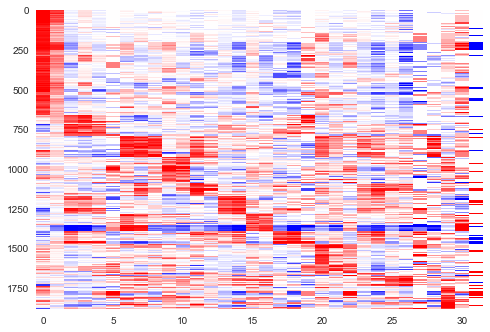

In [176]:
centroids_mmrf = miner.getCentroids(states,mosaicDf)
plt.imshow(centroids_mmrf.loc[mosaicDf.index,:],cmap="bwr",aspect="auto")
plt.grid(False)

## Map datasets to training set transcriptional states

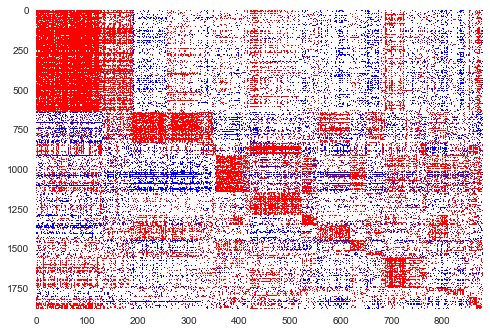

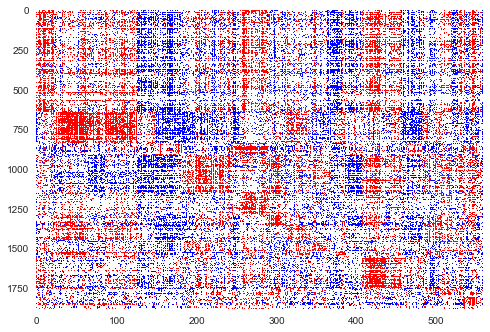

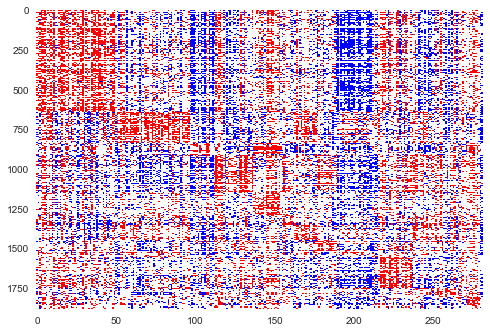

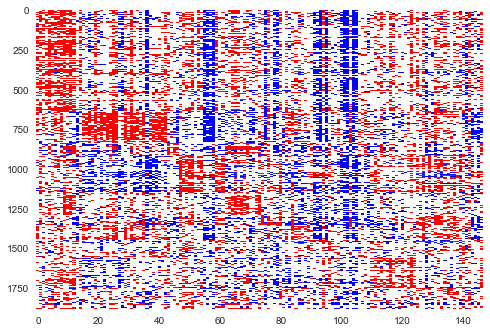

In [229]:
ordered_regulons = orderedDM.index

difference_complete = overExpressedMembersMatrix-underExpressedMembersMatrix

centroid_mapping = [[] for i in range(centroids_mmrf.shape[1])]
ordered_patients = np.hstack(states)
for i in range(len(ordered_patients)):
    corr_ = miner.pearson_array(array=np.array(centroids_mmrf.loc[ordered_regulons,:]).T,vector=np.array(difference_complete.loc[ordered_regulons,ordered_patients[i]]))
    centroid_mapping[np.argmax(corr_)].append(ordered_patients[i])
    
plt.imshow(difference_complete.loc[orderedDM.index,np.hstack(centroid_mapping)],cmap="bwr",aspect="auto")
plt.grid(False)
plt.savefig(os.path.join(resultsDirectory,"centroid_map_MMRF.pdf"),bbox_inches="tight")

centroid_mapping_GSE24080UAMS = [[] for i in range(centroids_mmrf.shape[1])]
ordered_patients = np.hstack(difference_complete_GSE24080UAMS.columns)
for i in range(len(ordered_patients)):
    corr_ = miner.pearson_array(array=np.array(centroids_mmrf.loc[ordered_regulons,:]).T,vector=np.array(difference_complete_GSE24080UAMS.loc[ordered_regulons,ordered_patients[i]]))
    centroid_mapping_GSE24080UAMS[np.argmax(corr_)].append(ordered_patients[i])

plt.figure()
plt.imshow(difference_complete_GSE24080UAMS.loc[orderedDM.index,np.hstack(centroid_mapping_GSE24080UAMS)],cmap="bwr",aspect="auto")
plt.grid(False)
plt.savefig(os.path.join(resultsDirectory,"centroid_map_GSE24080UAMS.pdf"),bbox_inches="tight")

centroid_mapping_GSE19784HOVON65 = [[] for i in range(len(centroidClusters))]
ordered_patients = np.hstack(difference_complete_GSE19784HOVON65.columns)
for i in range(len(ordered_patients)):
    corr_ = miner.pearson_array(array=np.array(centroidMatrix.loc[ordered_regulons,:]).T,vector=np.array(difference_complete_GSE19784HOVON65.loc[ordered_regulons,ordered_patients[i]]))
    centroid_mapping_GSE19784HOVON65[np.argmax(corr_)].append(ordered_patients[i])
    
plt.figure()
plt.imshow(difference_complete_GSE19784HOVON65.loc[orderedDM.index,np.hstack(centroid_mapping_GSE19784HOVON65)],cmap="bwr",aspect="auto")
plt.grid(False)
plt.savefig(os.path.join(resultsDirectory,"centroid_map_GSE19784HOVON65.pdf"),bbox_inches="tight")

centroid_mapping_EMTAB4032 = [[] for i in range(len(centroidClusters))]
ordered_patients = np.hstack(difference_complete_EMTAB4032.columns)
for i in range(len(ordered_patients)):
    corr_ = miner.pearson_array(array=np.array(centroidMatrix.loc[ordered_regulons,:]).T,vector=np.array(difference_complete_EMTAB4032.loc[ordered_regulons,ordered_patients[i]]))
    centroid_mapping_EMTAB4032[np.argmax(corr_)].append(ordered_patients[i])

plt.figure()
plt.imshow(difference_complete_EMTAB4032.loc[orderedDM.index,np.hstack(centroid_mapping_EMTAB4032)],cmap="bwr",aspect="auto")
plt.grid(False)
plt.savefig(os.path.join(resultsDirectory,"centroid_map_EMTAB4032.pdf"),bbox_inches="tight")

## Training survival data

In [1089]:
# load survival data
survivalMMRF = pd.read_csv(os.path.join("..","data","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix


In [1090]:
#generate Kaplan-Meier estimates
kmDf = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfMMRF = miner.guanRank(kmSurvival=kmDf)

In [1063]:
# GSE24080UAMS
expressionDataGSE24080UAMS = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","GSE24080UAMSentrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE24080UAMS, _ = miner.identifierConversion(expressionData=expressionDataGSE24080UAMS)
expressionDataGSE24080UAMS = miner.zscore(expressionDataGSE24080UAMS)
bkgdGSE24080UAMS = miner.backgroundDf(expressionDataGSE24080UAMS)
overExpressedMembersGSE24080UAMS = miner.biclusterMembershipDictionary(regulonModules,bkgdGSE24080UAMS,label=2,p=0.1)
overExpressedMembersMatrixGSE24080UAMS = miner.membershipToIncidence(overExpressedMembersGSE24080UAMS,expressionDataGSE24080UAMS)

# # GSE19784HOVON65 
expressionDataGSE19784HOVON65 = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","GSE19784HOVON65entrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE19784HOVON65, _ = miner.identifierConversion(expressionData=expressionDataGSE19784HOVON65)
expressionDataGSE19784HOVON65 = miner.zscore(expressionDataGSE19784HOVON65)
bkgdGSE19784HOVON65 = miner.backgroundDf(expressionDataGSE19784HOVON65)
overExpressedMembersGSE19784HOVON65 = miner.biclusterMembershipDictionary(regulonModules,bkgdGSE19784HOVON65,label=2,p=0.1)
overExpressedMembersMatrixGSE19784HOVON65 = miner.membershipToIncidence(overExpressedMembersGSE19784HOVON65,expressionDataGSE19784HOVON65)

# # EMTAB4032
expressionDataEMTAB4032 = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","EMTAB4032entrezIDlevel.csv"),index_col=0,header=0)
expressionDataEMTAB4032, _ = miner.identifierConversion(expressionData=expressionDataEMTAB4032)
expressionDataEMTAB4032 = miner.zscore(expressionDataEMTAB4032)
bkgdEMTAB4032 = miner.backgroundDf(expressionDataEMTAB4032)
overExpressedMembersEMTAB4032 = miner.biclusterMembershipDictionary(regulonModules,bkgdEMTAB4032,label=2,p=0.1)
overExpressedMembersMatrixEMTAB4032 = miner.membershipToIncidence(overExpressedMembersEMTAB4032,expressionDataEMTAB4032)


completed identifier conversion.
16998 genes were converted.
completed z-transformation.
done!
completed identifier conversion.
16998 genes were converted.
completed z-transformation.
done!
completed identifier conversion.
17228 genes were converted.
completed z-transformation.
done!


In [1064]:
survival = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","globalClinTraining.csv"),index_col=0,header=0)

survivalGSE24080UAMS = survival[survival.index=='GSE24080UAMS']
survivalGSE24080UAMS.index = survivalGSE24080UAMS.iloc[:,0]
survivalGSE24080UAMS.head(3)
survivalDfGSE24080UAMS = survivalGSE24080UAMS.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfGSE24080UAMS.columns = ["duration","observed"]

survivalGSE19784HOVON65 = survival[survival.index=='HOVON65']
survivalGSE19784HOVON65.index = survivalGSE19784HOVON65.iloc[:,0]
survivalGSE19784HOVON65.head(3)
survivalDfGSE19784HOVON65 = survivalGSE19784HOVON65.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfGSE19784HOVON65.columns = ["duration","observed"]

survivalEMTAB4032 = survival[survival.index=='EMTAB4032']
survivalEMTAB4032.index = survivalEMTAB4032.iloc[:,0]
survivalEMTAB4032.head(3)
survivalDfEMTAB4032 = survivalEMTAB4032.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfEMTAB4032.columns = ["duration","observed"]

In [1065]:
#generate Kaplan-Meier estimates
kmDf = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfMMRF = miner.guanRank(kmSurvival=kmDf)

#generate Kaplan-Meier estimates for GuanRank analysis
kmDf = miner.kmAnalysis(survivalDf=survivalDfGSE24080UAMS,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfGSE24080UAMS = miner.guanRank(kmSurvival=kmDf)

#generate Kaplan-Meier estimates for GuanRank analysis
kmDf = miner.kmAnalysis(survivalDf=survivalDfGSE19784HOVON65,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfGSE19784HOVON65 = miner.guanRank(kmSurvival=kmDf)

#generate Kaplan-Meier estimates for GuanRank analysis
kmDf = miner.kmAnalysis(survivalDf=survivalDfEMTAB4032,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfEMTAB4032 = miner.guanRank(kmSurvival=kmDf)

## Logic-based predictor

In [198]:
reload(miner)
Srvs = [guanSurvivalDfMMRF,guanSurvivalDfGSE24080UAMS]
Dfs = [overExpressedMembersMatrixMMRF,overExpressedMembersMatrixGSE24080UAMS]
pred_dict = miner.predictor(Dfs,Srvs,levels=50,numTrials=10,threshold=0.05,override=None,predictorFile = os.path.join(resultsDirectory,"predictor_dictionary.json"))

2.5024616344201333e-15
['97', '2676', '1634', '2501', '1091', '2704']
1.4235599110327182e-13
['1024', '2930', '1949', '3110']
3.5446719913134025e-06
['97', '2286', '1100', '2523', '1856']
2.6064423875783383e-08
['2730', '2677', '1475', '116', '738', '2005']
3.315511860934034e-05
['2778', '2609', '496', '845', '2584', '1754', '1037']
0.0006276236608938529
['638', '3117', '647']
0.004324572194355296
['2959', '2923', '2120', '1707', '3066', '190', '1448', '2097']
0.005012872756779592
['2776', '2343', '651', '1378']
5.640168781102664e-09
['2730', '73', '2015', '504', '1987']
0.013431530555980868
['81', '2500', '2833']
0.0006260298126983787
['2776', '1356', '1856', '2426', '2940']
6.128468844807185e-09
['1843', '1972', '712']
0.0007545833519352433
['2942', '2692', '1369', '2778', '1309', '651', '1628', '1856']
0.030225539862066192
['2878', '2727']
4.2639623499738204e-07
['1310', '829', '1614']
2.9783093631759284e-06
['2019', '1084', '1542', '0', '721']
2.074318819422745e-15
['1241', '872', 

/Users/MattWall/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


0.00045787542445495594
['81']
0.05696088665920701
completed in 1.177 minutes


## Decision tree predictor

In [1066]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import tree

In [1255]:

from sklearn.metrics import roc_auc_score



ValueError: Found input variables with inconsistent numbers of samples: [1757, 615]

In [1186]:
srv2 = guanSurvivalDfGSE24080UAMS.copy()
mtrx2 = overExpressedMembersMatrixGSE24080UAMS.copy()
#mtrx2 = difference_complete_GSE24080UAMS.copy()

high_risk_cutoff = 0.20

highRiskSamples = list(srv2.index[0:int(high_risk_cutoff*srv2.shape[0])])
lowRiskSamples = list(srv2.index[int(high_risk_cutoff*srv2.shape[0]):])

hrFlag = pd.DataFrame(np.ones((len(highRiskSamples),1)).astype(int))
hrFlag.index = highRiskSamples
hrFlag.columns = ["HR_FLAG"]

lrFlag = pd.DataFrame(np.zeros((len(lowRiskSamples),1)).astype(int))
lrFlag.index = lowRiskSamples
lrFlag.columns = ["HR_FLAG"]

hrMatrix2 = pd.concat([mtrx2.loc[:,highRiskSamples].T,hrFlag],axis=1)
lrMatrix2 = pd.concat([mtrx2.loc[:,lowRiskSamples].T,lrFlag],axis=1)
predictionMatrix2 = pd.concat([hrMatrix2,lrMatrix2],axis=0)
predictionMatrix2.head()

0    1    2    3    4    5    6    7    8    9   ...     3194  \
GSM592666  1.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0   ...      0.0   
GSM592664  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   ...      0.0   
GSM592815  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0   ...      0.0   
GSM592658  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...      0.0   
GSM592451  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...      0.0   

           3195  3196  3197  3198  3199  3200  3201  3202  HR_FLAG  
GSM592666   0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0        1  
GSM592664   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0        1  
GSM592815   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0        1  
GSM592658   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0        1  
GSM592451   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0        1  

[5 rows x 3204 columns]

In [1187]:
srv3 = guanSurvivalDfGSE19784HOVON65.copy()
mtrx3 = overExpressedMembersMatrixGSE19784HOVON65.copy()
#mtrx2 = difference_complete_GSE24080UAMS.copy()

high_risk_cutoff = 0.20

highRiskSamples = list(srv3.index[0:int(high_risk_cutoff*srv3.shape[0])])
lowRiskSamples = list(srv3.index[int(high_risk_cutoff*srv3.shape[0]):])

hrFlag = pd.DataFrame(np.ones((len(highRiskSamples),1)).astype(int))
hrFlag.index = highRiskSamples
hrFlag.columns = ["HR_FLAG"]

lrFlag = pd.DataFrame(np.zeros((len(lowRiskSamples),1)).astype(int))
lrFlag.index = lowRiskSamples
lrFlag.columns = ["HR_FLAG"]

hrMatrix3 = pd.concat([mtrx3.loc[:,highRiskSamples].T,hrFlag],axis=1)
lrMatrix3 = pd.concat([mtrx3.loc[:,lowRiskSamples].T,lrFlag],axis=1)
predictionMatrix3 = pd.concat([hrMatrix3,lrMatrix3],axis=0)
predictionMatrix3.head()

0    1    2    3    4    5    6    7    8    9   ...     3194  \
GSM494072  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0   ...      1.0   
GSM493989  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0   ...      0.0   
GSM494134  1.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0   ...      0.0   
GSM494114  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   ...      0.0   
GSM494109  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   ...      0.0   

           3195  3196  3197  3198  3199  3200  3201  3202  HR_FLAG  
GSM494072   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0        1  
GSM493989   0.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0        1  
GSM494134   1.0   0.0   1.0   1.0   1.0   0.0   0.0   1.0        1  
GSM494114   0.0   0.0   1.0   1.0   1.0   0.0   0.0   1.0        1  
GSM494109   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0        1  

[5 rows x 3204 columns]

In [1188]:
srv4 = guanSurvivalDfEMTAB4032.copy()
mtrx4 = overExpressedMembersMatrixEMTAB4032.copy()
#mtrx2 = difference_complete_GSE24080UAMS.copy()

high_risk_cutoff = 0.20

highRiskSamples = list(srv4.index[0:int(high_risk_cutoff*srv4.shape[0])])
lowRiskSamples = list(srv4.index[int(high_risk_cutoff*srv4.shape[0]):])

hrFlag = pd.DataFrame(np.ones((len(highRiskSamples),1)).astype(int))
hrFlag.index = highRiskSamples
hrFlag.columns = ["HR_FLAG"]

lrFlag = pd.DataFrame(np.zeros((len(lowRiskSamples),1)).astype(int))
lrFlag.index = lowRiskSamples
lrFlag.columns = ["HR_FLAG"]

hrMatrix4 = pd.concat([mtrx4.loc[:,highRiskSamples].T,hrFlag],axis=1)
lrMatrix4 = pd.concat([mtrx4.loc[:,lowRiskSamples].T,lrFlag],axis=1)
predictionMatrix4 = pd.concat([hrMatrix4,lrMatrix4],axis=0)
predictionMatrix4.head()

0    1    2    3    4    5    6    7    8    9   ...     3194  \
MM-11-145  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   ...      0.0   
MM-12-140  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0   ...      0.0   
MM-10-050  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...      1.0   
MM-11-001  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   ...      1.0   
MM-11-095  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...      0.0   

           3195  3196  3197  3198  3199  3200  3201  3202  HR_FLAG  
MM-11-145   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0        1  
MM-12-140   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0        1  
MM-10-050   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0        1  
MM-11-001   0.0   1.0   1.0   0.0   0.0   1.0   0.0   0.0        1  
MM-11-095   0.0   1.0   1.0   1.0   0.0   0.0   0.0   0.0        1  

[5 rows x 3204 columns]

In [1189]:
srv = guanSurvivalDfMMRF.copy()
mtrx = overExpressedMembersMatrix.copy()
#mtrx = difference_complete.copy()

high_risk_cutoff = 0.20

highRiskSamples = list(srv.index[0:int(high_risk_cutoff*srv.shape[0])])
lowRiskSamples = list(srv.index[int(high_risk_cutoff*srv.shape[0]):])

hrFlag = pd.DataFrame(np.ones((len(highRiskSamples),1)).astype(int))
hrFlag.index = highRiskSamples
hrFlag.columns = ["HR_FLAG"]

lrFlag = pd.DataFrame(np.zeros((len(lowRiskSamples),1)).astype(int))
lrFlag.index = lowRiskSamples
lrFlag.columns = ["HR_FLAG"]

hrMatrix = pd.concat([mtrx.loc[:,highRiskSamples].T,hrFlag],axis=1)
lrMatrix = pd.concat([mtrx.loc[:,lowRiskSamples].T,lrFlag],axis=1)
predictionMatrix = pd.concat([hrMatrix,lrMatrix],axis=0)
predictionMatrix.head()

hrMatrixCombined = pd.concat([hrMatrix,hrMatrix2,hrMatrix3,hrMatrix4],axis=0)
lrMatrixCombined = pd.concat([lrMatrix,lrMatrix2,lrMatrix3,lrMatrix4],axis=0)
predictionMatrixCombined = pd.concat([hrMatrixCombined,lrMatrixCombined],axis=0)
predictionMatrixCombined.head()

0    1    2    3    4    5    6    7    8    9   ...     \
MMRF_2754_1_BM  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   ...      
MMRF_2151_1_BM  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...      
MMRF_1450_1_BM  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   ...      
MMRF_1634_1_BM  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...      
MMRF_1778_1_BM  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0   ...      

                3194  3195  3196  3197  3198  3199  3200  3201  3202  HR_FLAG  
MMRF_2754_1_BM   1.0   0.0   0.0   1.0   1.0   1.0   1.0   0.0   1.0        1  
MMRF_2151_1_BM   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0        1  
MMRF_1450_1_BM   0.0   0.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0        1  
MMRF_1634_1_BM   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0        1  
MMRF_1778_1_BM   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0        1  

[5 rows x 3204 columns]

In [1334]:
predictionMatrix = predictionMatrixCombined

X = np.array(predictionMatrix.iloc[:,0:-1])
Y = np.array(predictionMatrix.iloc[:,-1])
X = X.astype('int')
Y = Y.astype('int')

best_state = 0
best_f1 = 0
best_auc = 0
aucs = []
for rs in range(100):
    X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.35, random_state = rs)

    clf_gini_pp2 = DecisionTreeClassifier(criterion = "gini", random_state = 12, max_depth=6, min_samples_leaf=5)
    clf_gini_pp2.fit(X_train, y_train)

    y_pred = clf_gini_pp2.predict(X_test)
    f1 = f1_score(y_test,y_pred)
    auc = roc_auc_score(y_test,y_pred)
    aucs.append(auc)

    #print("Accuracy is ", accuracy_score(y_test,y_pred)*100)
    print("F1-score is ", f1)
    print("ROC AUC is ", auc)
    
    if f1 > best_f1:
        best_f1 = f1
        
    if auc > best_auc:
        best_auc = auc        
        best_state = rs

print(best_state,best_auc)    
print(np.argsort(-np.array(aucs)))
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.35, random_state = best_state)

('F1-score is ', 0.3009708737864078)
('ROC AUC is ', 0.5736111111111111)
('F1-score is ', 0.26737967914438504)
('ROC AUC is ', 0.5616952426131743)
('F1-score is ', 0.21965317919075145)
('ROC AUC is ', 0.5438203994195288)
('F1-score is ', 0.3333333333333333)
('ROC AUC is ', 0.5867847454419279)
('F1-score is ', 0.25870646766169153)
('ROC AUC is ', 0.5527821460835814)
('F1-score is ', 0.3101604278074866)
('ROC AUC is ', 0.5827669652970857)
('F1-score is ', 0.2275449101796407)
('ROC AUC is ', 0.5505980618053673)
('F1-score is ', 0.1752577319587629)
('ROC AUC is ', 0.5153130781965137)
('F1-score is ', 0.36199095022624433)
('ROC AUC is ', 0.6024929399162527)
('F1-score is ', 0.2616822429906542)
('ROC AUC is ', 0.5497614178595774)
('F1-score is ', 0.3522727272727273)
('ROC AUC is ', 0.6055896762283443)
('F1-score is ', 0.19780219780219782)
('ROC AUC is ', 0.5329563056667097)
('F1-score is ', 0.3225806451612903)
('ROC AUC is ', 0.588501291989664)
('F1-score is ', 0.28431372549019607)
('ROC AUC

In [1357]:
predictionMatrix = predictionMatrixCombined

X = np.array(predictionMatrix.iloc[:,0:-1])
Y = np.array(predictionMatrix.iloc[:,-1])
X = X.astype('int')
Y = Y.astype('int')

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.35, random_state = 65)
clf_gini_pp2 = DecisionTreeClassifier(criterion = "gini", random_state = 12, max_depth=6, min_samples_leaf=5)
clf_gini_pp2.fit(X_train, y_train)
#clf_gini.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=12,
            splitter='best')

In [1358]:
y_pred = clf_gini_pp2.predict(X)
y_pred

print("Accuracy is ", accuracy_score(Y,y_pred)*100)
print("F1-score is ", f1_score(Y,y_pred))

('Accuracy is ', 84.4621513944223)
('F1-score is ', 0.553191489361702)


In [1359]:
y_pred = clf_gini_pp2.predict(X_test)
y_pred

print("Accuracy is ", accuracy_score(y_test,y_pred)*100)
print("F1-score is ", f1_score(y_test,y_pred))

('Accuracy is ', 78.86178861788618)
('F1-score is ', 0.380952380952381)


In [1379]:
from sklearn import tree
from sklearn.externals.six import StringIO  
import pydot 
dot_data = StringIO() 
tree.export_graphviz(clf_gini_pp2, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph[0].write_pdf(os.path.join(resultsDirectory,"decisionTreeAUC.pdf"))

In [1361]:
mmrf_predictions = clf_gini_pp2.predict(np.array(overExpressedMembersMatrix.T))
GSE24080UAMS_predictions = clf_gini_pp2.predict(np.array(overExpressedMembersMatrixGSE24080UAMS.T))
GSE19784HOVON65_predictions = clf_gini_pp2.predict(np.array(overExpressedMembersMatrixGSE19784HOVON65.T))
EMTAB4032_predictions = clf_gini_pp2.predict(np.array(overExpressedMembersMatrixEMTAB4032.T))

In [1375]:
lbls = EMTAB4032_predictions
mtrx = overExpressedMembersMatrixEMTAB4032
srv = survivalDfEMTAB4032.copy()
survival_tag = "EMTAB4032"

hr_dt = mtrx.columns[lbls.astype(bool)]
lr_dt = mtrx.columns[(1-lbls).astype(bool)]

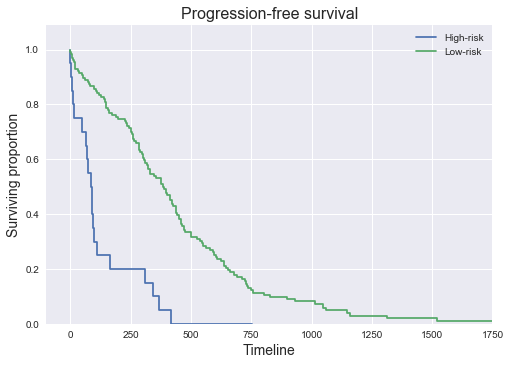

In [1376]:
reload(miner)
kmTag = "decision_tree"
kmFilename = ("_").join([survival_tag,predictor_tag,kmTag,"high-risk",".pdf"])

groups = [hr_dt,lr_dt]
labels = ["High-risk","Low-risk"]

plotName = os.path.join(resultsDirectory,kmFilename)
miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),filename=plotName)   

In [1377]:
cox_vectors = []
srv_set = set(srv.index)
for i in range(len(groups)):
    group = groups[i]
    patients = list(set(group)&srv_set)
    tmp_df = pd.DataFrame(np.zeros(srv.shape[0]))
    tmp_df.index = srv.index
    tmp_df.columns = [labels[i]]
    tmp_df.loc[patients,labels[i]] = 1
    cox_vectors.append(tmp_df)
    
pre_cox = pd.concat(cox_vectors,axis=1).T
pre_cox.head(5)
    
cox_dict = miner.parallelMemberSurvivalAnalysis(membershipDf = pre_cox,numCores=1,survivalPath="",survivalData=srv)
print(cox_dict)

/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['High-risk'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)
/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['Low-risk'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)

{'High-risk': (4.563885117332983, 5.021556447013302e-06), 'Low-risk': (-4.563885117332984, 5.021556447013271e-06)}


In [1378]:
len(hr_dt)/float(overExpressedMembersMatrixEMTAB4032.shape[1])

0.1360544217687075

In [805]:
# save the model to disk
filename = os.path.join(resultsDirectory,'finalized_miner_predictor.sav')
pickle.dump(clf_gini, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8065040650406504


## High-risk predictor

In [935]:
regulonModules = miner.read_json(os.path.join(resultsDirectory,"regulons.json"))
model_filename = os.path.join(resultsDirectory,'finalized_miner_predictor.sav')
expressionDf = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","GSE24080UAMSentrezIDlevel.csv"),index_col=0,header=0)

high_risk_labels, low_risk_labels = miner.predictRisk(expressionDf,regulonModules,model_filename)

completed identifier conversion.
16998 genes were converted.
completed z-transformation.
done!


## Miscellaneous code to ignore

In [910]:
reload(miner)
df = overExpressedMembersMatrix.copy()
srv = survivalDfMMRF.copy()
scoresDf = miner.predictorScores(df,srv,pred_dict)
thresholdsMMRF = miner.predictorThresholds(scoresDf)
thresholdsMMRF = [4,2,-2,-5]
pred_classes = miner.predictClasses(scoresDf,thresholdsMMRF)
survival_tag = "MMRF"
predictor_tag = "mmrf;uams_expt"
srv = guanSurvivalDfMMRF.copy()
print(thresholdsMMRF)

[4, 2, -2, -5]


In [926]:
reload(miner)
df = overExpressedMembersMatrixGSE24080UAMS.copy()
srv = survivalDfGSE24080UAMS.copy()
scoresDf = miner.predictorScores(df,srv,pred_dict)
#thresholdsMMRF = miner.predictorThresholds(scoresDf)
thresholdsMMRF = [3.5, 2, -2, -5]
pred_classes = miner.predictClasses(scoresDf,thresholdsMMRF)
survival_tag = "GSE24080UAMS"
predictor_tag = "mmrf;uams_expt"
srv = guanSurvivalDfGSE24080UAMS.copy()
print(thresholdsMMRF)

[3.5, 2, -2, -5]


In [686]:
reload(miner)
df = overExpressedMembersMatrixGSE19784HOVON65.copy()
srv = survivalDfGSE19784HOVON65.copy()
scoresDf = miner.predictorScores(df,srv,pred_dict)
#thresholdsMMRF = miner.predictorThresholds(scoresDf)
thresholdsMMRF = [4,2,-2,-5]
pred_classes = miner.predictClasses(scoresDf,thresholdsMMRF)
survival_tag = "GSE19784HOVON65"
predictor_tag = "mmrf;uams_expt"
srv = guanSurvivalDfGSE19784HOVON65.copy()
print(thresholdsMMRF)

[4, 2, -2, -5]


In [692]:
reload(miner)
df = overExpressedMembersMatrixEMTAB4032.copy()
srv = survivalDfEMTAB4032.copy()
scoresDf = miner.predictorScores(df,srv,pred_dict)
#thresholdsMMRF = miner.predictorThresholds(scoresDf)
thresholdsMMRF = [3, 2, -2, -5]
pred_classes = miner.predictClasses(scoresDf,thresholdsMMRF)
survival_tag = "EMTAB4032"
predictor_tag = "mmrf;uams_expt"
srv = guanSurvivalDfEMTAB4032.copy()
print(thresholdsMMRF)

[3, 2, -2, -5]


In [226]:
vhr_ = list(pred_classes.index[np.where(pred_classes.iloc[:,0]==5)[0]])
vlr_ = list(pred_classes.index[np.where(pred_classes.iloc[:,0]==1)[0]])
hr_ = list(pred_classes.index[np.where(pred_classes.iloc[:,0]==4)[0]])
lr_ = list(pred_classes.index[np.where(pred_classes.iloc[:,0]==2)[0]])
avg_ = list(pred_classes.index[np.where(pred_classes.iloc[:,0]==3)[0]])
total = float(len(vhr_)+len(hr_)+len(avg_)+len(lr_)+len(vlr_))
print(len(vhr_)/total,len(hr_)/total,len(avg_)/total,len(lr_)/total,len(vlr_)/total)

(0.11806797853309481, 0.06440071556350627, 0.5867620751341681, 0.13237924865831843, 0.09838998211091235)


In [388]:
guan_srv = pd.DataFrame(srv.loc[:,"GuanScore"])
guan_srv.columns = ["value"]
guan_srv_group = pd.DataFrame(np.zeros(guan_srv.shape[0]))
guan_srv_group.index = guan_srv.index
guan_srv_group.columns = ["group"]
guan_srv_df = pd.concat([guan_srv,guan_srv_group],axis=1)


groups = [hr_dt,[]]
labels = ["High-risk","All patients"]
for i in range(len(groups)):
    group = groups[i]
    label = labels[i]
    guan_srv_df.loc[group,"group"] = label
    
import seaborn as sns
b = sns.boxplot(x='group', y='value', data=guan_srv_df,order=labels,palette="colorblind")
b.axes.set_title(survival_tag,fontsize=14)
b.set_xlabel("",fontsize=0)
b.set_ylabel("PFS GuanRank",fontsize=14)
b.tick_params(labelsize=14)
#sns.plt.show()

groups = [[],srv.index]
labels = ["High-risk","All patients"]
for i in range(len(groups)):
    group = groups[i]
    label = labels[i]
    guan_srv_df.loc[group,"group"] = label

c = sns.boxplot(x='group', y='value', data=guan_srv_df,order=labels,palette="colorblind")
c.axes.set_title(survival_tag,fontsize=14)
c.set_xlabel("",fontsize=0)
c.set_ylabel("PFS GuanRank",fontsize=14)
c.tick_params(labelsize=14)
sns.plt.show()
boxplotFilename = ("_").join([survival_tag,predictor_tag,"high-risk","boxplot.pdf"])

plt.savefig(os.path.join(resultsDirectory,boxplotFilename),bbox_inches="tight")
#sns.stripplot(x='group', y='value', data=guan_srv_df,order=labels,color="orange", jitter=0.2, size=2.5)

KeyError: "Index([u'MMRF_1931_2_BM', u'MMRF_1686_2_BM', u'MMRF_1229_3_BM',\n       u'MMRF_2187_1_PB', u'MMRF_1500_2_BM', u'MMRF_1889_2_BM',\n       u'MMRF_1049_4_BM', u'MMRF_2059_2_BM', u'MMRF_1639_3_BM',\n       u'MMRF_1659_4_BM', u'MMRF_1790_4_PB', u'MMRF_1049_2_BM',\n       u'MMRF_1927_1_PB', u'MMRF_1671_5_BM', u'MMRF_1137_4_BM',\n       u'MMRF_1229_2_BM', u'MMRF_1913_3_BM', u'MMRF_2087_2_BM',\n       u'MMRF_1157_5_BM', u'MMRF_1024_2_BM', u'MMRF_1965_1_PB',\n       u'MMRF_1790_3_BM', u'MMRF_1256_2_BM', u'MMRF_1157_4_BM',\n       u'MMRF_2126_2_BM', u'MMRF_1061_3_BM', u'MMRF_1219_2_BM',\n       u'MMRF_1462_4_BM', u'MMRF_2039_2_BM', u'MMRF_1838_3_BM',\n       u'MMRF_1085_3_BM', u'MMRF_1992_1_PB', u'MMRF_1380_2_BM',\n       u'MMRF_1783_2_BM', u'MMRF_2076_2_BM', u'MMRF_1851_1_PB',\n       u'MMRF_2083_2_BM', u'MMRF_1110_2_BM', u'MMRF_1269_3_BM',\n       u'MMRF_2122_3_BM', u'MMRF_1024_3_BM', u'MMRF_2562_2_BM',\n       u'MMRF_1201_4_BM', u'MMRF_1671_4_BM', u'MMRF_2419_2_BM',\n       u'MMRF_1030_3_BM', u'MMRF_1790_4_BM', u'MMRF_1235_2_BM',\n       u'MMRF_2011_2_BM', u'MMRF_2194_2_BM', u'MMRF_2344_2_BM',\n       u'MMRF_1157_2_BM', u'MMRF_1992_2_BM', u'MMRF_2606_2_BM',\n       u'MMRF_1205_2_BM', u'MMRF_1401_2_BM', u'MMRF_1137_3_BM',\n       u'MMRF_1157_3_BM', u'MMRF_1179_2_BM', u'MMRF_1433_2_BM',\n       u'MMRF_2601_2_BM', u'MMRF_1462_3_BM', u'MMRF_1565_3_BM',\n       u'MMRF_1293_4_BM', u'MMRF_2085_3_BM', u'MMRF_1978_2_BM',\n       u'MMRF_1309_2_BM', u'MMRF_2401_2_BM', u'MMRF_1533_2_BM',\n       u'MMRF_2363_2_BM', u'MMRF_1193_3_BM', u'MMRF_1223_2_BM'],\n      dtype='object') not in index"

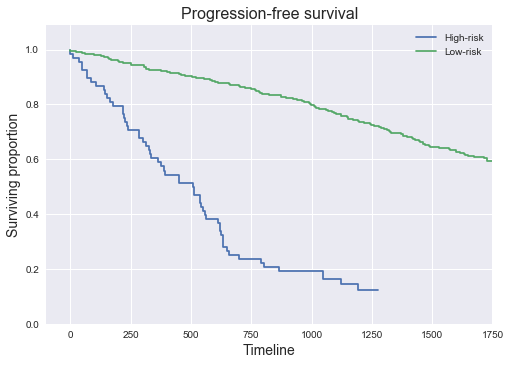

In [938]:
reload(miner)
kmTag = "decision_tree"
kmFilename = ("_").join([survival_tag,predictor_tag,kmTag,"high-risk",".pdf"])

groups = [hr_dt,lr_dt]
labels = ["High-risk","Low-risk"]

plotName = os.path.join(resultsDirectory,kmFilename)
miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),filename=plotName)    

In [928]:
len(hr_dt)

68

In [914]:

groups = [hr_dt,lr_dt]
labels = ["High-risk","Others"]
cox_vectors = []
srv_set = set(srv.index)
for i in range(len(groups)):
    group = groups[i]
    patients = list(set(group)&srv_set)
    tmp_df = pd.DataFrame(np.zeros(srv.shape[0]))
    tmp_df.index = srv.index
    tmp_df.columns = [labels[i]]
    tmp_df.loc[patients,labels[i]] = 1
    cox_vectors.append(tmp_df)
    
pre_cox = pd.concat(cox_vectors,axis=1).T
pre_cox.head(5)
    
cox_dict = miner.parallelMemberSurvivalAnalysis(membershipDf = pre_cox,numCores=1,survivalPath="",survivalData=srv)
print(cox_dict)

{'High-risk': (7.660203324321584, 1.8563894864911894e-14), 'Others': (-7.660203324321579, 1.8563894864912632e-14)}


1. load and pre-process expressionData
2. map expressionData to regulons (only decision tree regulons necessary)
3. prepare overExpressedMembersMatrix from regulon membership
4. load and apply decision tree model to overExpressedMembersMatrix.T
5. convert positive classifications into original labels
6. ensure classifications are properly presented for quantification

In [ ]:
# Generate ROC curves using high-risk labels and varying the PFS day considered to be high-risk.

In [840]:
clf_gini.feature_importances_.argsort()[-5]

2495

In [850]:
overExpressedMembersMatrix.index[2526]

'2526'

In [822]:
"'ENSG00000051596'".split("'")

['', 'ENSG00000051596', '']

In [861]:
geneset = regulonModules['950']
#stripped_genes = [gene.split("'")[1] for gene in geneset]
np.savetxt(os.path.join(resultsDirectory,"output_genes.txt"),geneset,fmt="%1.50s",comments="")

In [862]:
geneset

['ENSG00000179841',
 'ENSG00000188486',
 'ENSG00000177565',
 'ENSG00000114861',
 'ENSG00000085449',
 'ENSG00000205208',
 'ENSG00000167632',
 'ENSG00000117592',
 'ENSG00000153767',
 'ENSG00000152518',
 'ENSG00000183864',
 'ENSG00000163006',
 'ENSG00000170340',
 'ENSG00000114744']

In [863]:
regulonDf[regulonDf.Regulon_ID=='950']

Regulon_ID        Regulator             Gene
13731        950  ENSG00000143842  ENSG00000179841
13732        950  ENSG00000143842  ENSG00000188486
13733        950  ENSG00000143842  ENSG00000177565
13734        950  ENSG00000143842  ENSG00000114861
13735        950  ENSG00000143842  ENSG00000085449
13736        950  ENSG00000143842  ENSG00000205208
13737        950  ENSG00000143842  ENSG00000167632
13738        950  ENSG00000143842  ENSG00000117592
13739        950  ENSG00000143842  ENSG00000153767
13740        950  ENSG00000143842  ENSG00000152518
13741        950  ENSG00000143842  ENSG00000183864
13742        950  ENSG00000143842  ENSG00000163006
13743        950  ENSG00000143842  ENSG00000170340
13744        950  ENSG00000143842  ENSG00000114744

## mirna inference

In [880]:
# generate formatted revisedClusters data for input into FIRM
firm_df = miner.generateInputForFIRM(revisedClusters,resultsDirectory)

## Pre-processing

In [939]:
# preprocess mmrf data
expressionDf = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","MMRF_CoMMpass_IA9_E74GTF_Salmon_Gene_TPM.txt"),index_col=0,header=0,sep="\t")


In [955]:
mmrf_tpm_processed = miner.transformFPKM(expressionData=expressionDf,fpkm_threshold=0.05,highlyExpressed=True)

In [960]:
reload(miner)
high_risk_labels, low_risk_labels = miner.predictRisk(expressionDf=mmrf_tpm_processed,regulonModules=regulonModules,model_filename=model_filename)

completed identifier conversion.
9104 genes were converted.
completed z-transformation.


KeyError: "None of [[u'ENSG00000136404', u'ENSG00000139946', u'ENSG00000167566', u'ENSG00000120885', u'ENSG00000124795', u'ENSG00000204634']] are in the [index]"

In [ ]:
import pickle

expressionDf, _ = identifierConversion(expressionData=expressionDf)
expressionDf = zscore(expressionDf)
bkgdDf = backgroundDf(expressionDf)
overExpressedMembers = biclusterMembershipDictionary(regulonModules,bkgdDf,label=2,p=0.1)
overExpressedMembersMatrix = membershipToIncidence(overExpressedMembers,expressionDf)

labels = overExpressedMembersMatrix.columns
predictor_formatted = np.array(overExpressedMembersMatrix).T

loaded_model = pickle.load(open(model_filename, 'rb'))
prediction = loaded_model.predict(predictor_formatted)

hr_dt = labels[prediction.astype(bool)]
lr_dt = labels[(1-prediction).astype(bool)]


In [963]:
expressionDf = mmrf_tpm_processed.copy()
expressionDf, _ = miner.identifierConversion(expressionData=expressionDf)
expressionDf = miner.zscore(expressionDf)
bkgdDf = miner.backgroundDf(expressionDf)

completed identifier conversion.
9104 genes were converted.
completed z-transformation.


In [981]:
reload(miner)
overExpressedMembers1 = miner.biclusterMembershipDictionary(regulonModules,bkgdDf,label=2,p=0.1)
overExpressedMembersMatrix1 = miner.membershipToIncidence(overExpressedMembers1,expressionDf)


KeyError: "None of [[u'ENSG00000136404', u'ENSG00000139946', u'ENSG00000167566', u'ENSG00000120885', u'ENSG00000124795', u'ENSG00000204634']] are in the [index]"

In [983]:
1. quantile normailze with axis=0

KeyError: "None of [[u'ENSG00000136404', u'ENSG00000139946', u'ENSG00000167566', u'ENSG00000120885', u'ENSG00000124795', u'ENSG00000204634']] are in the [index]"

In [978]:
geneset

[u'ENSG00000136404',
 u'ENSG00000139946',
 u'ENSG00000167566',
 u'ENSG00000120885',
 u'ENSG00000124795',
 u'ENSG00000204634']

In [979]:
list(set(bkgdDf.index)&set(geneset))

[]

In [980]:
key

u'2447'

In [984]:
def assignMembership(geneset,background,p=0.05):

    cluster = background.loc[geneset,:]
    classNeg1 = len(geneset)-np.count_nonzero(cluster+1,axis=0)
    class0 = len(geneset)-np.count_nonzero(cluster,axis=0)
    class1 = len(geneset)-np.count_nonzero(cluster-1,axis=0)
    observations = zip(classNeg1,class0,class1)
    
    highpass = stats.binom.ppf(1-p/3,len(geneset),1./3)
    classes = []
    for i in range(len(observations)):
        check = np.where(np.array(observations[i])>=highpass)[0]
        if len(check)>1:
            check = np.array([np.argmax(np.array(observations[i]))])
        classes.append(check)
    
    return classes

In [994]:
reload(miner)
asd = miner.assignMembership(regulonModules['0'],bkgdDf,p=0.05)

In [989]:
mbrs = [np.array([]) for i in range(background.shape[1])]

In [995]:
asd

[array([0]),
 array([], dtype=int64),
 array([0]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([1]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([2]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([2]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([2]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([2]),
 array([2]),
 array([2]),
 array([], dtype=int64),
 array([1]),
 array([2]),
 array([], dtype=int64),
 array([0]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([0]),
 array([], dtype=int64),
 array([0]),
 array([], dtype=int64),
 array([0]),
 array([], dtype=int64),
 array([2]),
 array([0]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([0]),
 array([2]),
 array([], dtype=int64),
 ar

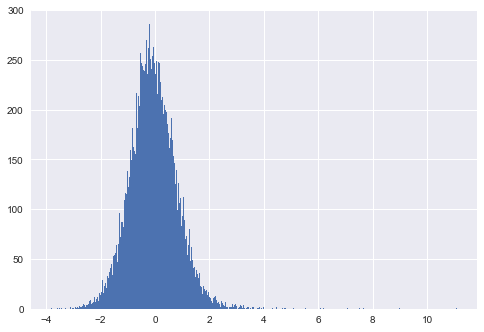

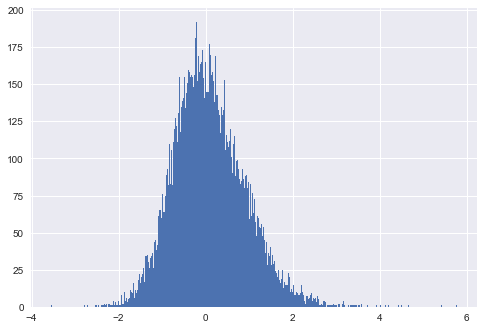

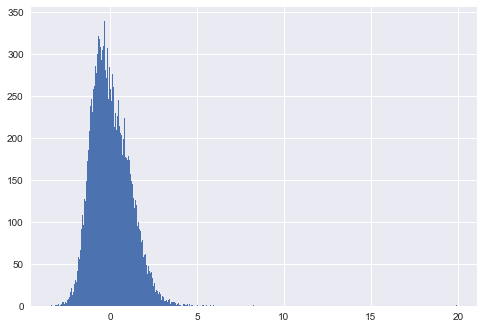

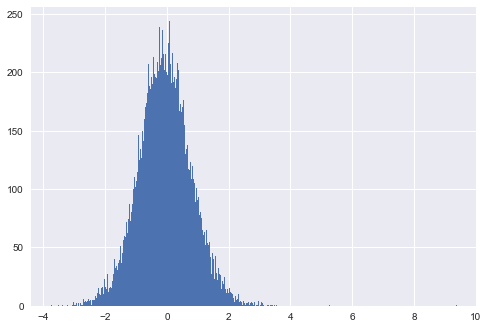

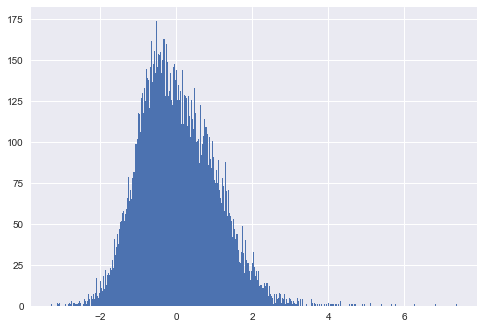

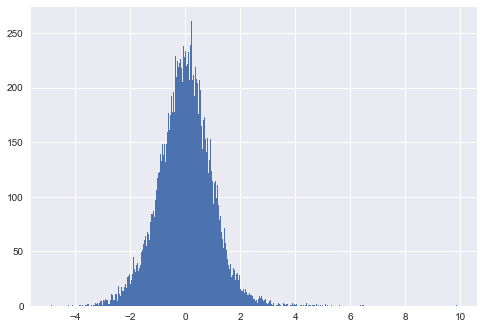

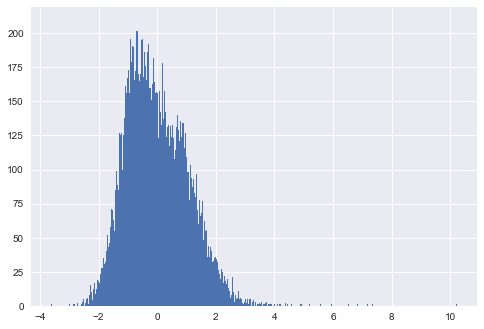

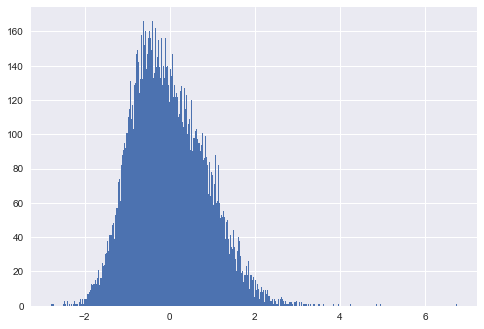

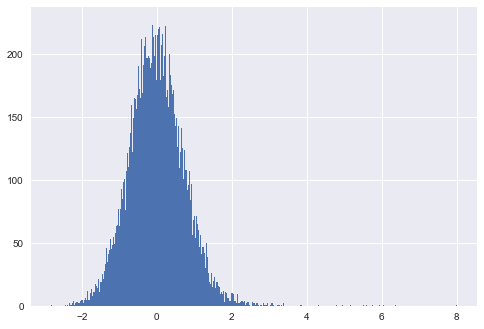

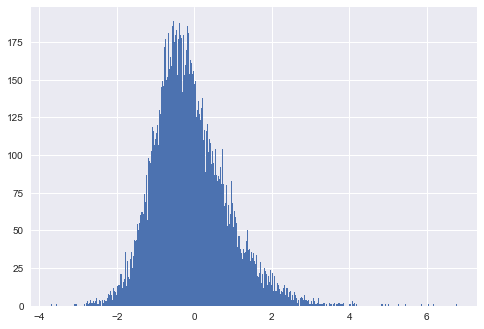

In [1419]:
for i in range(10):
    plt.figure()
    plt.hist(expressionDataGSE24080UAMS.iloc[:,i],bins=500)

(array([ 2.,  3.,  1.,  3.,  3.,  3.,  3.,  1.,  8.,  9., 11., 12., 19.,
        17., 17., 23., 19., 30., 18., 32., 28., 21., 25., 36., 39., 26.,
        31., 40., 44., 34., 43., 16., 19., 13., 23., 18.,  6., 15., 14.,
         5.,  7., 10., 14., 10.,  8.,  6.,  9.,  2.,  9.,  2.,  2.,  6.,
         2.,  4.,  4.,  2.,  5.,  5.,  4.,  2.,  6.,  2.,  3.,  3.,  1.,
         2.,  2.,  2.,  1.,  2.,  0.,  3.,  0.,  2.,  2.,  1.,  0.,  2.,
         1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.86687136, -0.83986786, -0.81286436, -0.78586086, -0.75885736,
        -0.73185386, -0.70485036, -0.67784686, -0.65084335, -0.62383985,
        -0.59683635, -0.56983285, -0.54282935, -0.51582585, -0.48882235,
        -0.46181885, -0.43481535, -0.40781185, -0.38080835, -0.35380485,
        -0.32680135, -0.29979784, -0.27279434, -0.24579084, -0.21878734,
        -0.19178384, -0.16478034, -0.13777684, -0.11077334, -0.083769

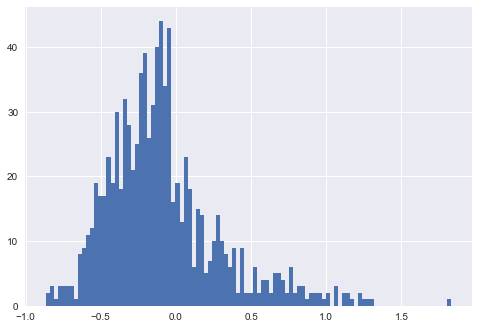

In [1403]:
plt.hist(np.nanmedian(expressionData,axis=0),bins=100)

In [1405]:
print(np.var(np.nanmedian(expressionData,axis=0)))

0.14313657788301742


(array([ 1.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  1.,  2.,  1.,
         0.,  2.,  0.,  1.,  0.,  0.,  1.,  3.,  1.,  7.,  7.,  2.,  2.,
         8.,  6., 11.,  6.,  6., 12., 10.,  3.,  9., 10., 12.,  7., 17.,
        20., 15., 30., 15., 14., 24., 32., 21., 15., 24., 19.,  9., 12.,
        14.,  9.,  8., 10., 10.,  8.,  9.,  8.,  3.,  4.,  9.,  1.,  9.,
         3.,  5.,  4.,  3.,  4.,  2.,  3.,  1.,  1.,  3.,  1.,  3.,  3.,
         0.,  3.,  0.,  3.,  3.,  2.,  0.,  1.,  0.,  1.,  1.,  2.,  0.,
         0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([-0.45409327, -0.44564715, -0.43720103, -0.42875491, -0.4203088 ,
        -0.41186268, -0.40341656, -0.39497044, -0.38652433, -0.37807821,
        -0.36963209, -0.36118597, -0.35273986, -0.34429374, -0.33584762,
        -0.3274015 , -0.31895539, -0.31050927, -0.30206315, -0.29361703,
        -0.28517092, -0.2767248 , -0.26827868, -0.25983256, -0.25138645,
        -0.24294033, -0.23449421, -0.22604809, -0.21760198, -0.209155

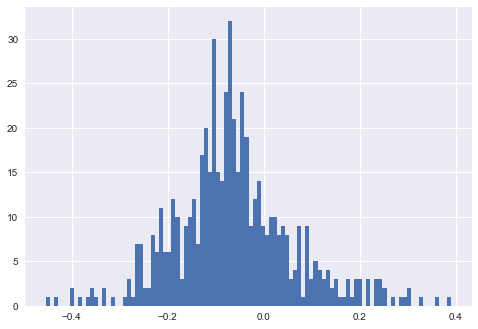

In [1382]:
plt.hist(meds,bins=100)

In [1411]:
#expressionDataGSE24080UAMS = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","GSE24080UAMSentrezIDlevel.csv"),index_col=0,header=0)
#expressionDataGSE24080UAMS, _ = miner.identifierConversion(expressionData=expressionDataGSE24080UAMS)


completed identifier conversion.
16998 genes were converted.


In [1424]:
def batchScale(expressionDf):
    maxs = []
    detections = []
    fraction99 = []
    top10s = []
    for i in range(expressionDf.shape[1]):
        pat0 = expressionDf.iloc[:,i]
        sort0 = np.sort(pat0)
        sum0 = sum(pat0)
        top10 = sum(sort0[-10:])/sum0
        percentMax = max(pat0)/sum0
        percentDetected = np.count_nonzero(pat0)/float(len(pat0))
        pat099 = np.sum(pat0[pat0<np.percentile(pat0,99)])/sum0
        maxs.append(percentMax)
        detections.append(percentDetected)
        fraction99.append(pat099)
        top10s.append(top10)

    scale = np.array(np.array(fraction99)/0.99)
    expressionDfScaled = expressionDf/scale

    return expressionDfScaled

In [1415]:
scale = np.array(np.array(fraction99)/0.99)
expressionDataGSE24080UAMS = expressionDataGSE24080UAMS/scale
#read file
#drop zeros
#check variance of medians for batch effect detection
#if less than threshold, proceed with analysis
#else, try np.log2(val+1) and repeat
#if still fail, apply bacth effect corrector

In [1416]:
expressionDataGSE24080UAMS = miner.zscore(expressionDataGSE24080UAMS)

completed z-transformation.


In [1447]:
medianAx1 = [np.median(expressionData.iloc[i,:][expressionData.iloc[i,:]>0]) for i in range(expressionData.shape[0])]
stdAx1 = [np.std(expressionData.iloc[i,:][expressionData.iloc[i,:]>0]) for i in range(expressionData.shape[0])]

preZscore = expressionData.copy()
medianCorrected = (preZscore.T-np.array(medianAx1)).T
Zscore = (medianCorrected.T/np.array(stdAx1)).T
#Zscore[Zscore<-4.01]=-4.01
#Zscore[Zscore>4.01] = 4.01

In [1451]:
min(expressionData.iloc[0,:])

0.0

(array([750.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.,   3.,   2.,   4.,   1.,   5.,   6.,   5.,   2.,   4.,   4.,
          3.,   4.,   4.,   1.,   5.,   3.,   0.,   2.,   1.,   3.,   1.,
          4.,   3.,   2.,   3.,   1.,   3.,   0.,   3.,   0.,   2.,   3.,
          1.,   0.,   2.,   1.,   1.,   3.,   0.,   0.,   1.,   1.,   2.,
          2.,   1.,   1.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   1.,
          1.,   1.,   0.,   2.,   0.,   2.,   0.,   0.,   1.,   1.,   1.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

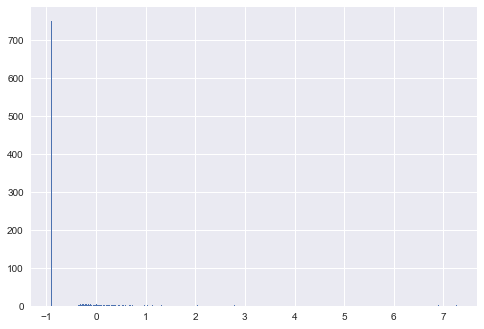

In [1458]:
plt.hist(Zscore.iloc[100,:],bins=500)

In [1464]:
matrix2.shape

(2000, 54)

      t-statistic       p-value
2669    18.897966  6.353696e-30
920     18.752480  3.059193e-43
1850    18.337104  2.470771e-42
1728    17.468170  6.027699e-35
926     16.952753  2.175569e-28
2744    16.718023  2.950986e-37
75      16.701042  2.483624e-38
1058    16.292524  6.238375e-35
1634    16.259172  2.296185e-36
2216    16.128342  1.799548e-31
3043    16.073222  9.539528e-27
1593    16.006159  6.394183e-33
46      15.942982  1.698663e-35
3169    15.859257  9.164689e-27
872     15.836111  1.187075e-29
3141    15.662585  2.169343e-32
2059    15.357890  7.192843e-32
134     15.331792  7.806286e-32
1391    15.063751  1.972576e-32
462     15.054464  2.548688e-31
1884    15.012877  2.942178e-31
828     14.985947  4.015502e-33
64      14.970985  1.394331e-33
791     14.946201  3.554730e-25
268     14.914746  4.563262e-24
2897    14.708265  2.669934e-27
1104    14.685114  3.786985e-26
181     14.476853  3.486457e-30
1876    14.394950  6.314515e-24
681     14.294044  2.797995e-31
...     

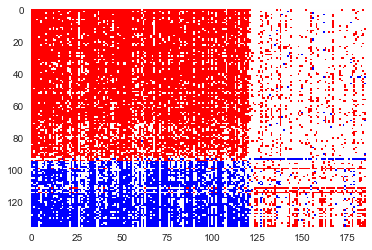

In [1510]:
# Example input:
states_list_1 = [states[0],states[1]]
states_list_2 = [states[10],states[11]]
reference_matrix = overExpressedMembersMatrix-underExpressedMembersMatrix
p = 1e-10

reload(miner)
results = miner.getStratifyingRegulons(states_list_1=states[0],states_list_2=states[1],reference_matrix=reference_matrix,p=1e-20,plot=True)

In [1508]:
top10 = list(results.index[0:10])
print(top10)

['175', '1523', '2570', '2001', '995', '2868', '1298', '2030', '2722', '888']


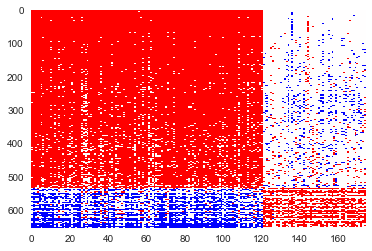

In [1491]:
figure = plt.figure()
ax = figure.gca()
ax.imshow(ttest_data_source,cmap="bwr",aspect="auto")
ax.grid(False)

In [ ]:
ranked_states = np.argsort(xmedians)

survival_tag = "Risk_groups"
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='group', y='value', data=guan_srv_df,order=ranked_states)
for patch in ax.artists:
    patch.set_edgecolor('black')
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.8))

sns.swarmplot(x='group', y='value',data=guan_srv_df,order=np.argsort(xmedians),size=5, color=[0.15,0.15,0.15],edgecolor="black")
    
plt.ylabel("Risk score",FontSize=20)
plt.xlabel("Subtype",FontSize=20)
boxplotFilename = ("_").join([survival_tag,"boxplot_swarm.pdf"])
plt.savefig(os.path.join(resultsDirectory,boxplotFilename),bbox_inches="tight")


In [1483]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

inline_rc = dict(mpl.rcParams)